# Module

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error, r2_score

import optuna
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="seaborn")
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

In [2]:
%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
np.random.seed(2024)
random.seed(2024)

# Data

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [6]:
train.shape, test.shape

((1200000, 21), (800000, 20))

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 21 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   id                    1200000 non-null  int64  
 1   Age                   1181295 non-null  float64
 2   Gender                1200000 non-null  object 
 3   Annual Income         1155051 non-null  float64
 4   Marital Status        1181471 non-null  object 
 5   Number of Dependents  1090328 non-null  float64
 6   Education Level       1200000 non-null  object 
 7   Occupation            841925 non-null   object 
 8   Health Score          1125924 non-null  float64
 9   Location              1200000 non-null  object 
 10  Policy Type           1200000 non-null  object 
 11  Previous Claims       835971 non-null   float64
 12  Vehicle Age           1199994 non-null  float64
 13  Credit Score          1062118 non-null  float64
 14  Insurance Duration    1199999 non-

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    800000 non-null  int64  
 1   Age                   787511 non-null  float64
 2   Gender                800000 non-null  object 
 3   Annual Income         770140 non-null  float64
 4   Marital Status        787664 non-null  object 
 5   Number of Dependents  726870 non-null  float64
 6   Education Level       800000 non-null  object 
 7   Occupation            560875 non-null  object 
 8   Health Score          750551 non-null  float64
 9   Location              800000 non-null  object 
 10  Policy Type           800000 non-null  object 
 11  Previous Claims       557198 non-null  float64
 12  Vehicle Age           799997 non-null  float64
 13  Credit Score          708549 non-null  float64
 14  Insurance Duration    799998 non-null  float64
 15  

The target variable is `Premium Amount` column.

# EDA

In [9]:
numerical_columns = train.dtypes[train.dtypes != 'object']
numerical_columns = [col for col in numerical_columns.index.tolist() if col not in ['id', 'Premium Amount']]
numerical_columns

['Age',
 'Annual Income',
 'Number of Dependents',
 'Health Score',
 'Previous Claims',
 'Vehicle Age',
 'Credit Score',
 'Insurance Duration']

In [10]:
print('The mean of columns')
print(train[numerical_columns].mean())

print('=' * 45)
print('The std of columns')
print(train[numerical_columns].std())

print('=' * 45)
print('The skewness of columns')
print(train[numerical_columns].skew())

The mean of columns
Age                        41.145563
Annual Income           32745.217777
Number of Dependents        2.009934
Health Score               25.613908
Previous Claims             1.002689
Vehicle Age                 9.569889
Credit Score              592.924350
Insurance Duration          5.018219
dtype: float64
The std of columns
Age                        13.539950
Annual Income           32179.506124
Number of Dependents        1.417338
Health Score               12.203462
Previous Claims             0.982840
Vehicle Age                 5.776189
Credit Score              149.981945
Insurance Duration          2.594331
dtype: float64
The skewness of columns
Age                    -0.012532
Annual Income           1.470357
Number of Dependents   -0.013255
Health Score            0.282187
Previous Claims         0.905321
Vehicle Age            -0.020409
Credit Score           -0.113573
Insurance Duration     -0.008793
dtype: float64


> Skewness Analysis and Transformation

- **Annual Income**:  
  - Skewness = **1.47** (Highly skewed).  
  - Log transformation or square root transformation is recommended to normalize the distribution.

- **Previous Claims**:  
  - Skewness = **0.91** (Moderately skewed).  
  - Further analysis of the data distribution is required.  
  - Consider transformations or binning based on the observed distribution and business context.

In [11]:
for col in numerical_columns:
    print(f'{col} has {train[col].nunique()} unique values')

Age has 47 unique values
Annual Income has 88593 unique values
Number of Dependents has 5 unique values
Health Score has 532657 unique values
Previous Claims has 10 unique values
Vehicle Age has 20 unique values
Credit Score has 550 unique values
Insurance Duration has 9 unique values


> Numerical Columns Analysis  

- All columns are suitable to be treated as **numerical (Ratio)** features.  
- **Age, Vehicle Age, Insurance Duration**: Represent time or continuous scales → Not appropriate for categorization.  
- **Number of Dependents, Previous Claims**: Discrete values but have numeric significance → Maintain as continuous variables.  

In [12]:
object_columns = train.dtypes[train.dtypes == 'object'].index.tolist()
object_columns

['Gender',
 'Marital Status',
 'Education Level',
 'Occupation',
 'Location',
 'Policy Type',
 'Policy Start Date',
 'Customer Feedback',
 'Smoking Status',
 'Exercise Frequency',
 'Property Type']

In [13]:
for col in object_columns:
    num_unique = train[col].nunique()
    print(f'{col} has {num_unique} unique categories')

Gender has 2 unique categories
Marital Status has 3 unique categories
Education Level has 4 unique categories
Occupation has 3 unique categories
Location has 3 unique categories
Policy Type has 3 unique categories
Policy Start Date has 167381 unique categories
Customer Feedback has 3 unique categories
Smoking Status has 2 unique categories
Exercise Frequency has 4 unique categories
Property Type has 3 unique categories


> Categorical Columns Analysis  

- Most object-type columns have a small number of unique categories, making them suitable for **categorical encoding**.  
- **Policy Start Date** has 167,381 unique values, representing dates.  
  - It is recommended to **convert this column to datetime format** for easier processing and feature extraction.

In [14]:
for col in object_columns:
    print(f'\nTop value counts in "{col}" : \n{train[col].value_counts().head(10)}')


Top value counts in "Gender" : 
Gender
Male      602571
Female    597429
Name: count, dtype: int64

Top value counts in "Marital Status" : 
Marital Status
Single      395391
Married     394316
Divorced    391764
Name: count, dtype: int64

Top value counts in "Education Level" : 
Education Level
Master's       303818
PhD            303507
Bachelor's     303234
High School    289441
Name: count, dtype: int64

Top value counts in "Occupation" : 
Occupation
Employed         282750
Self-Employed    282645
Unemployed       276530
Name: count, dtype: int64

Top value counts in "Location" : 
Location
Suburban    401542
Rural       400947
Urban       397511
Name: count, dtype: int64

Top value counts in "Policy Type" : 
Policy Type
Premium          401846
Comprehensive    399600
Basic            398554
Name: count, dtype: int64

Top value counts in "Policy Start Date" : 
Policy Start Date
2020-02-08 15:21:39.134960    142
2022-02-02 15:21:39.134960    137
2023-08-13 15:21:39.155231    137
2022

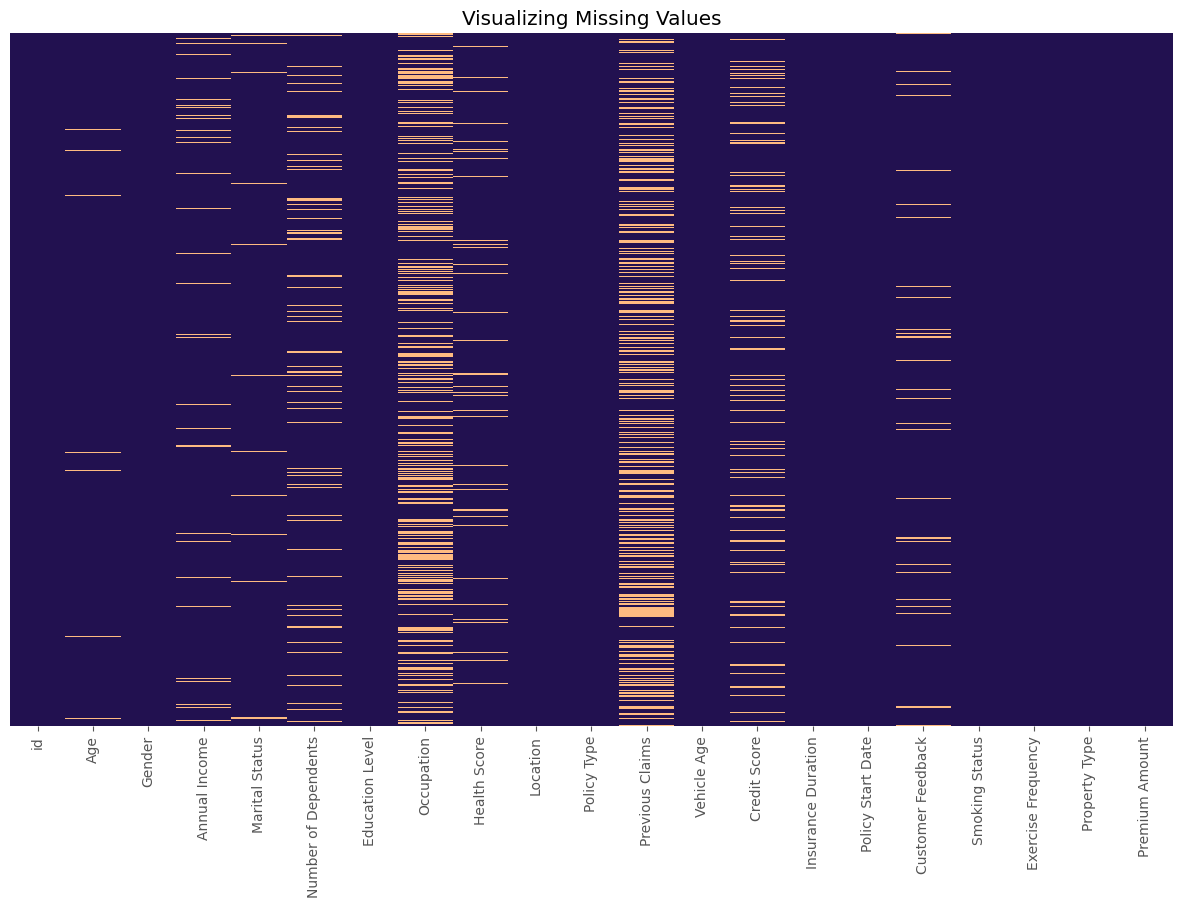

In [15]:
plt.figure(figsize=(15,9))
plt.title("Visualizing Missing Values")
sns.heatmap(train.isnull(), cbar=False, cmap=sns.color_palette('magma'), yticklabels=False);
plt.show()

> Missing Values Analysis  
- Several columns contain a significant number of **missing values**.  
- Appropriate **handling of missing values** (e.g., imputation or removal) will be necessary.  

# Visual Exploration

First, let's take a look at the `Premium Amount` distribution.

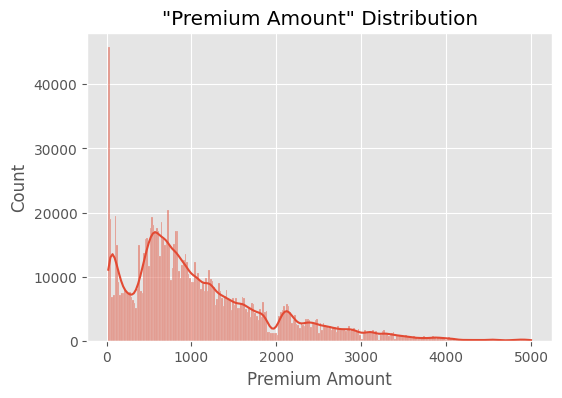

In [16]:
plt.figure(figsize=(6, 4))  
sns.histplot(train['Premium Amount'], kde=True)
plt.title('"Premium Amount" Distribution')
plt.show()

> Target Variable Distribution  
- The target variable appears to be **right-skewed**.  
- A **log transformation** may be required to normalize the distribution.  

In [17]:
def plot_num_col(df, col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
    gs = fig.add_gridspec(2, 2, width_ratios=[1, 2])

    if df[col].nunique() > 50:
        discrete = False
    else:
        discrete = True

    ax1 = fig.add_subplot(gs[0, 0])
    sns.histplot(df[col], ax=ax1, fill=True, discrete=discrete, common_norm=False)
    ax1.set_title(f'{col} Distribution')
    
    ax2 = fig.add_subplot(gs[1, 0])
    sns.boxplot(data=df, x=col, ax=ax2)
    ax2.set_title(f'{col} Box Plot')
    
    ax3 = fig.add_subplot(gs[:, 1])
    sns.violinplot(x=pd.cut(df[col].dropna(), bins=10), y=df['Premium Amount'], ax=ax3)
    ax3.set_title(f'Violin Plot')
    
    plt.tight_layout()
    plt.show()

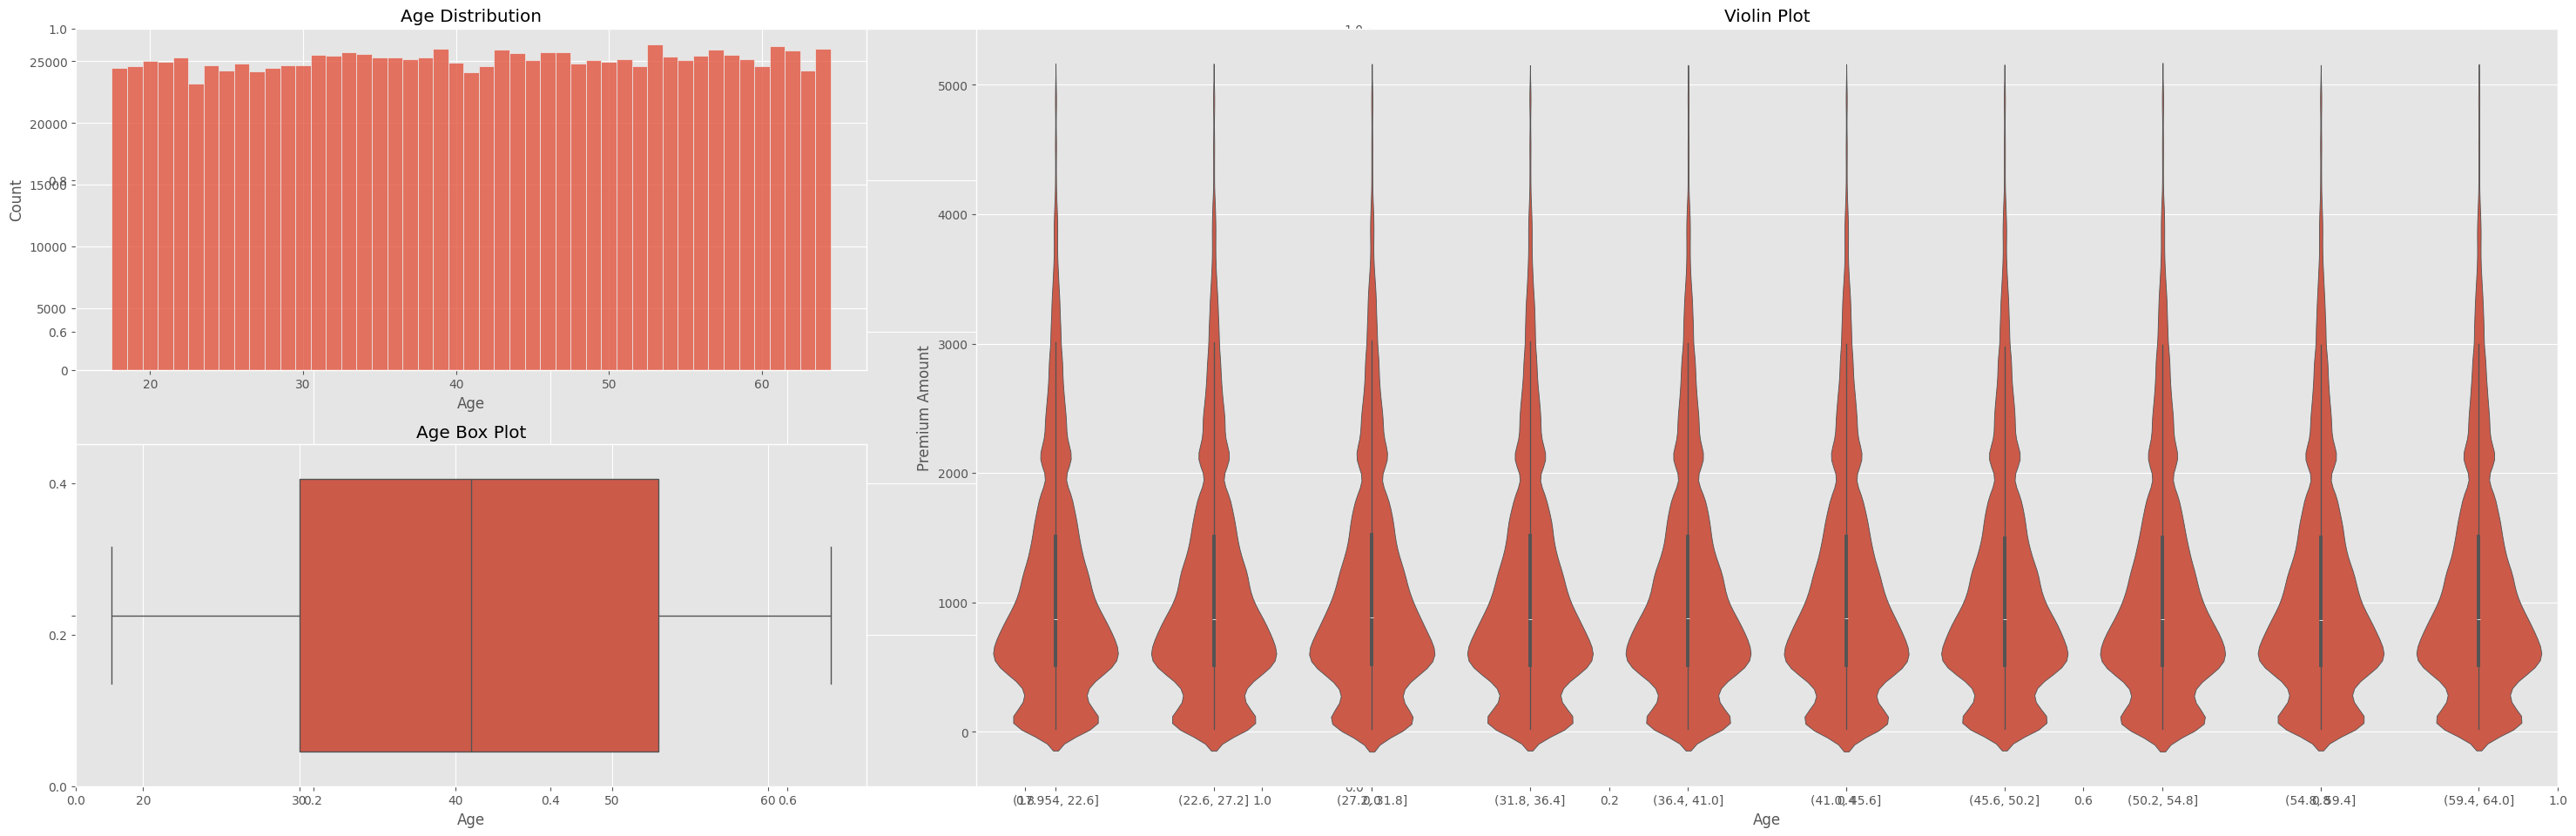

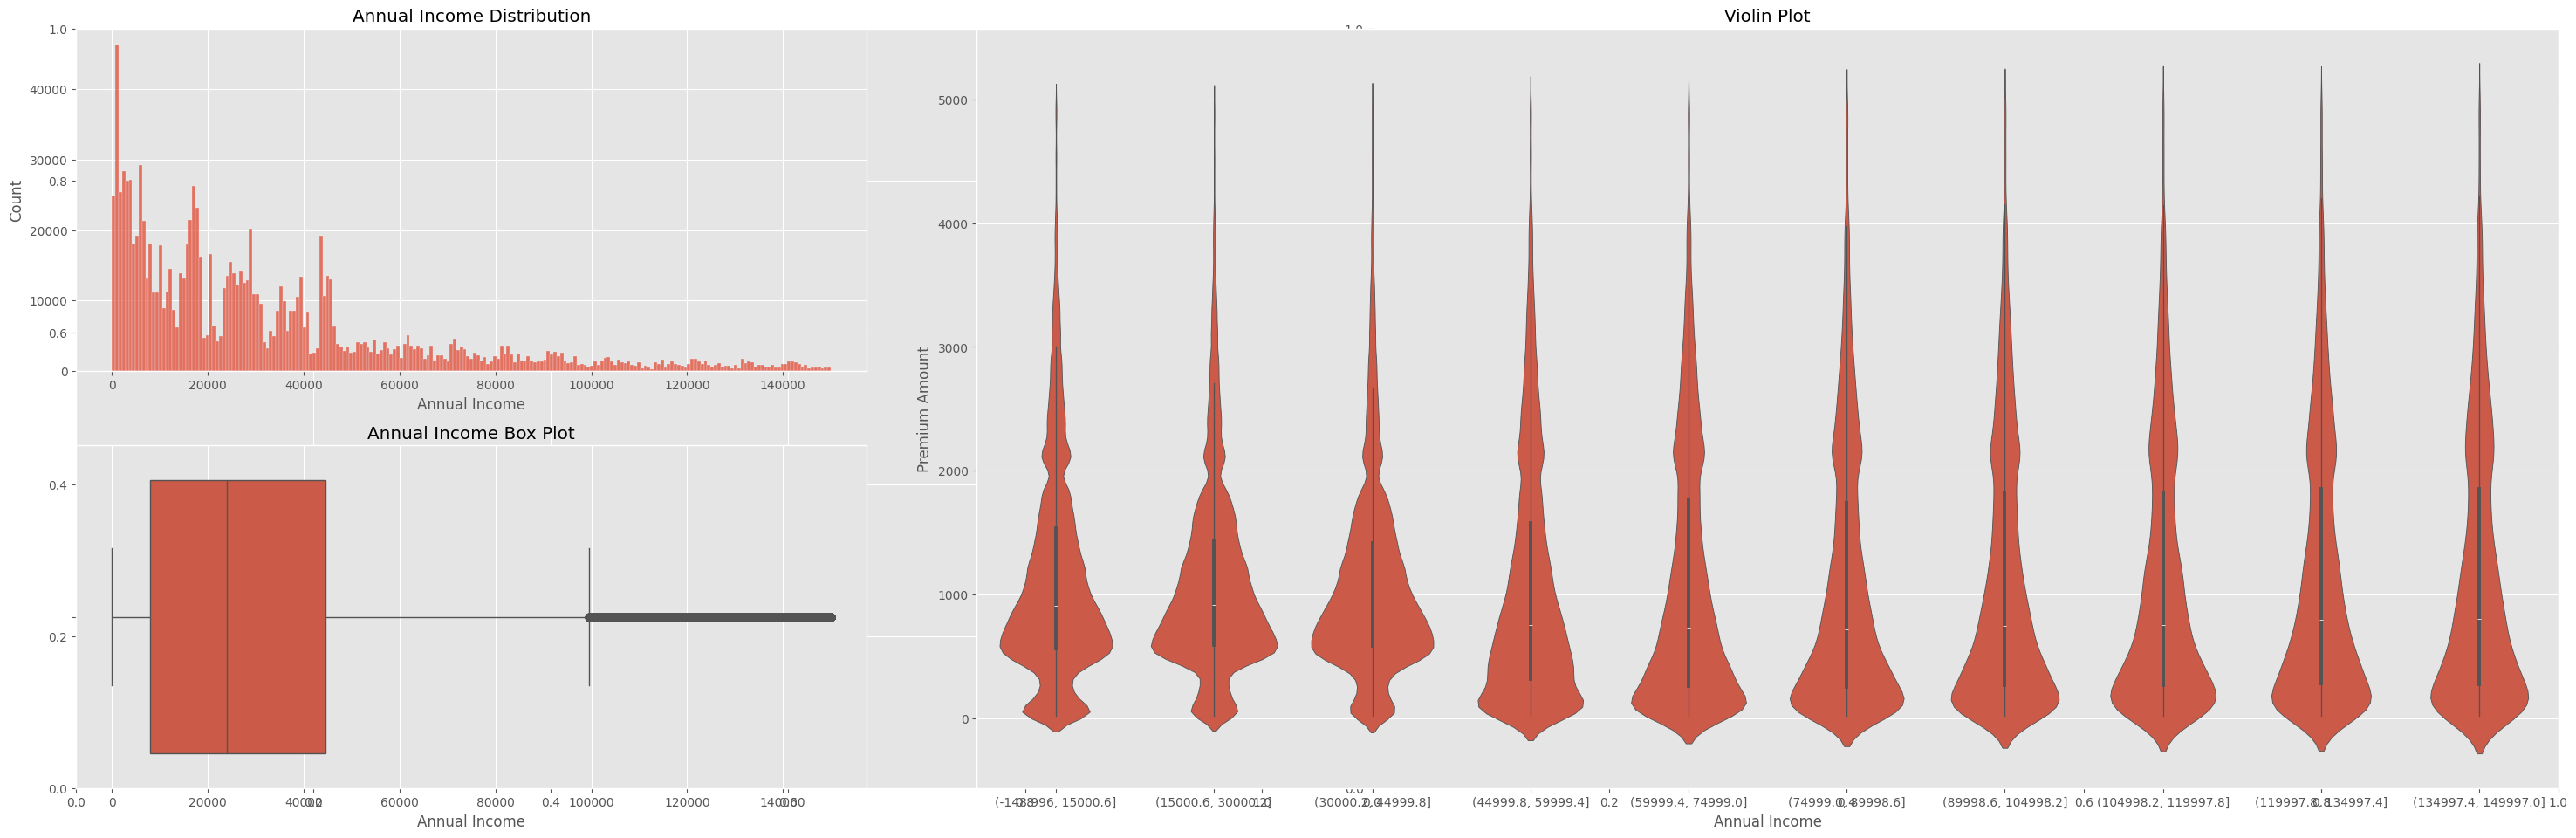

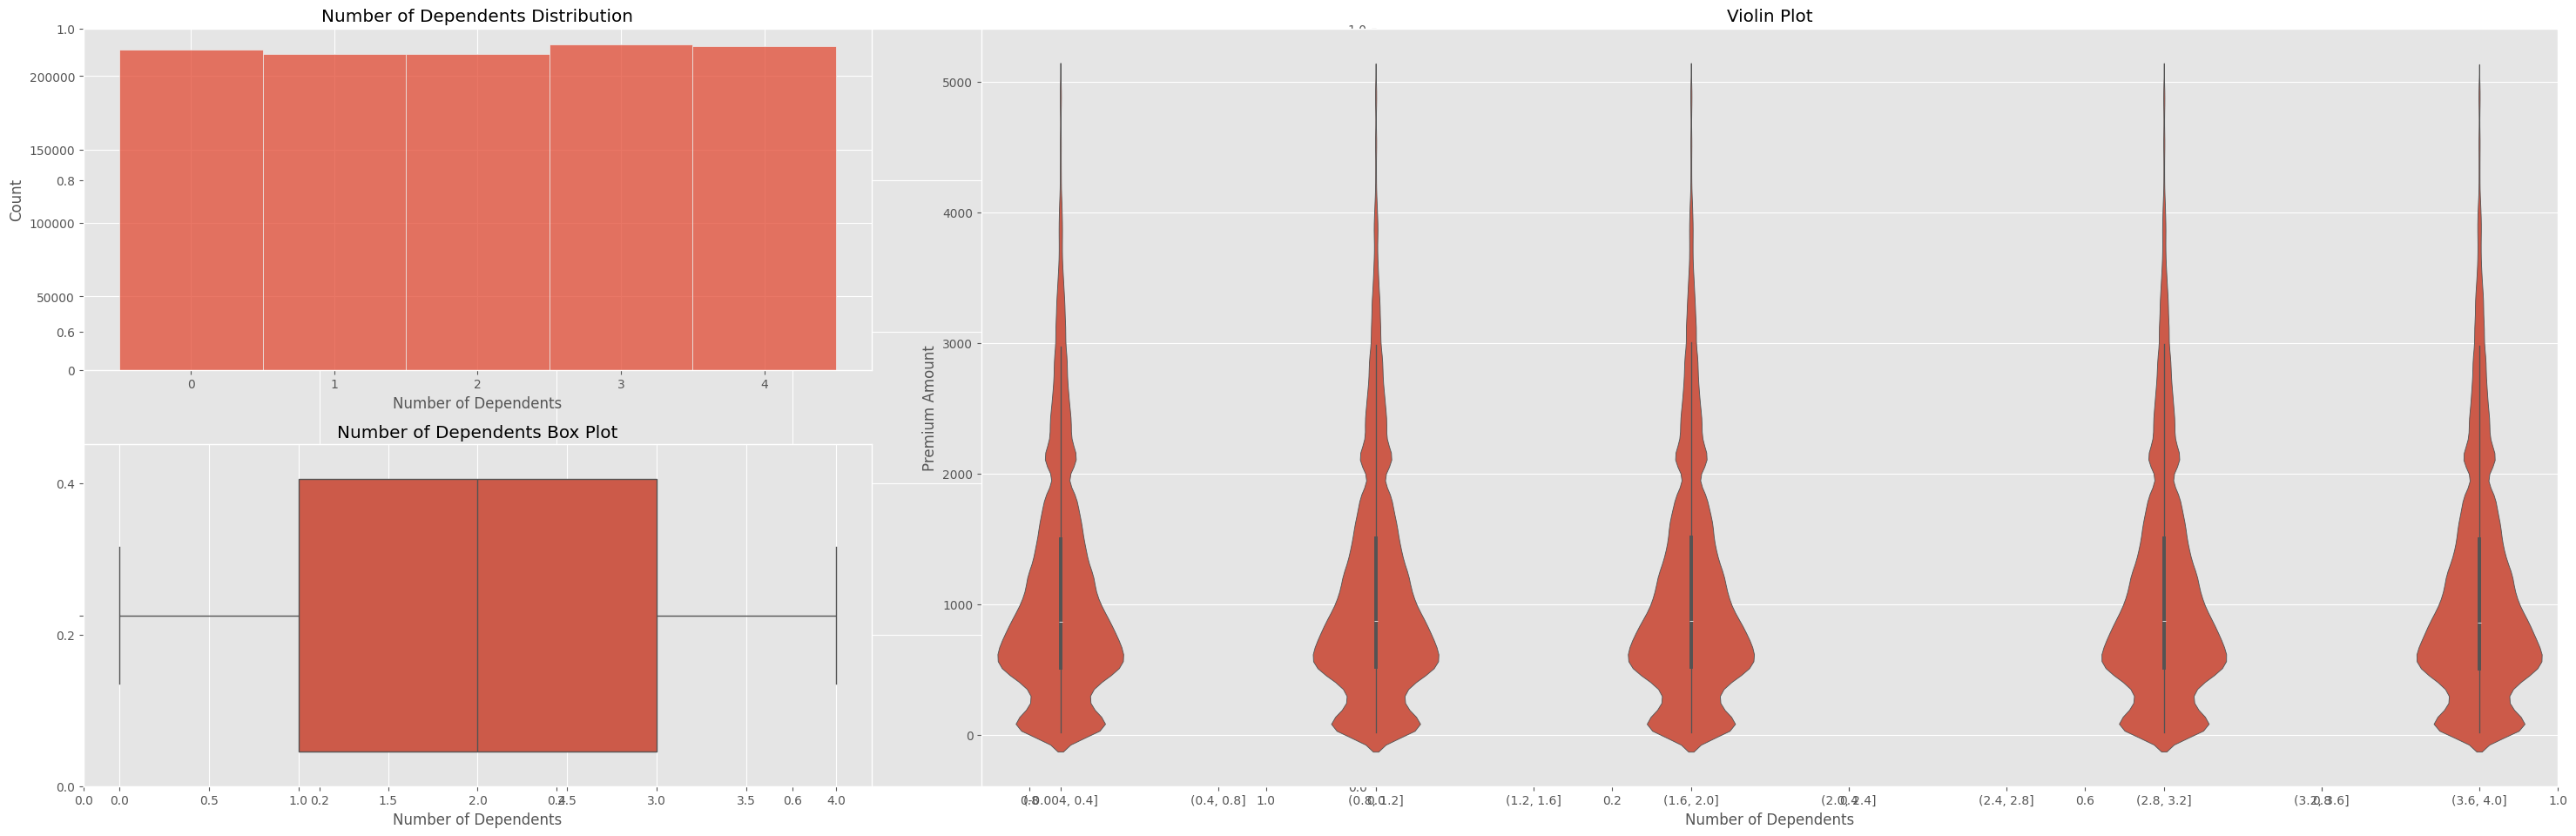

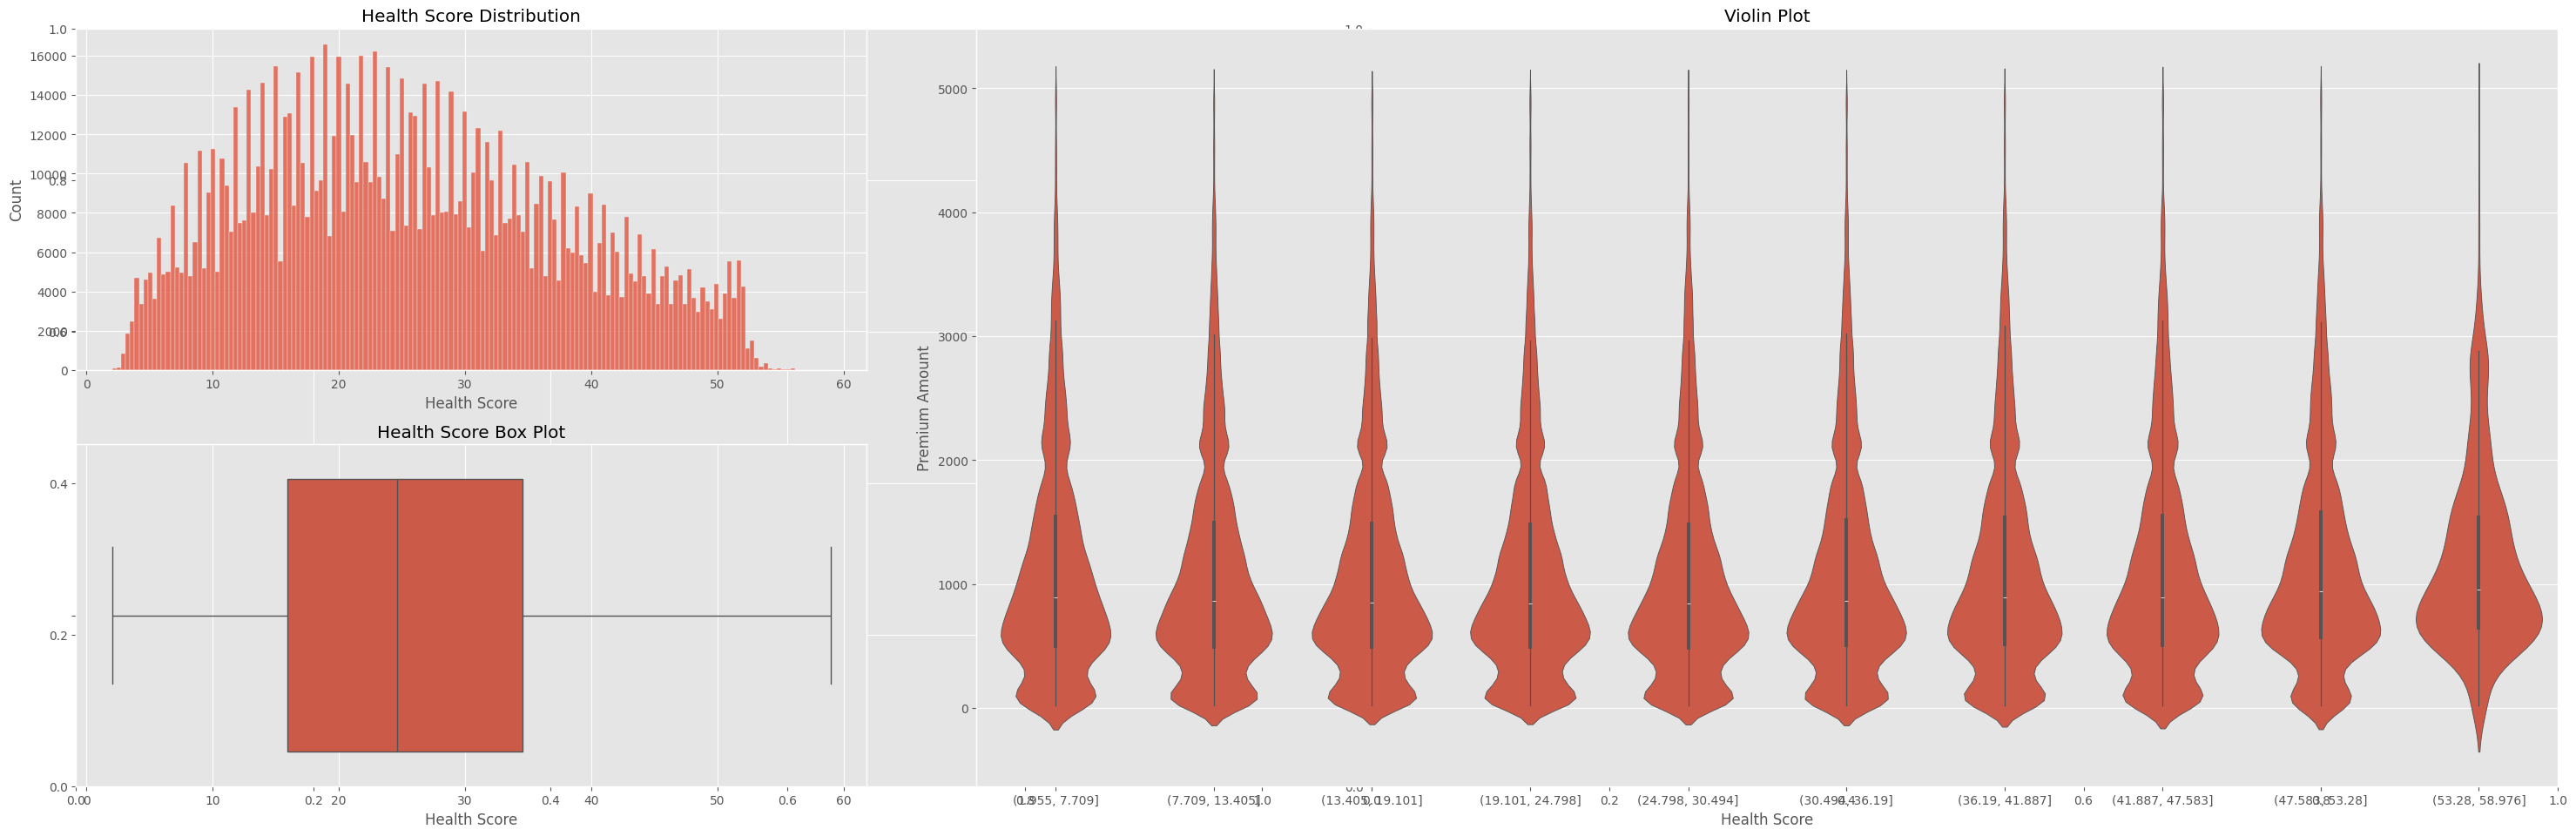

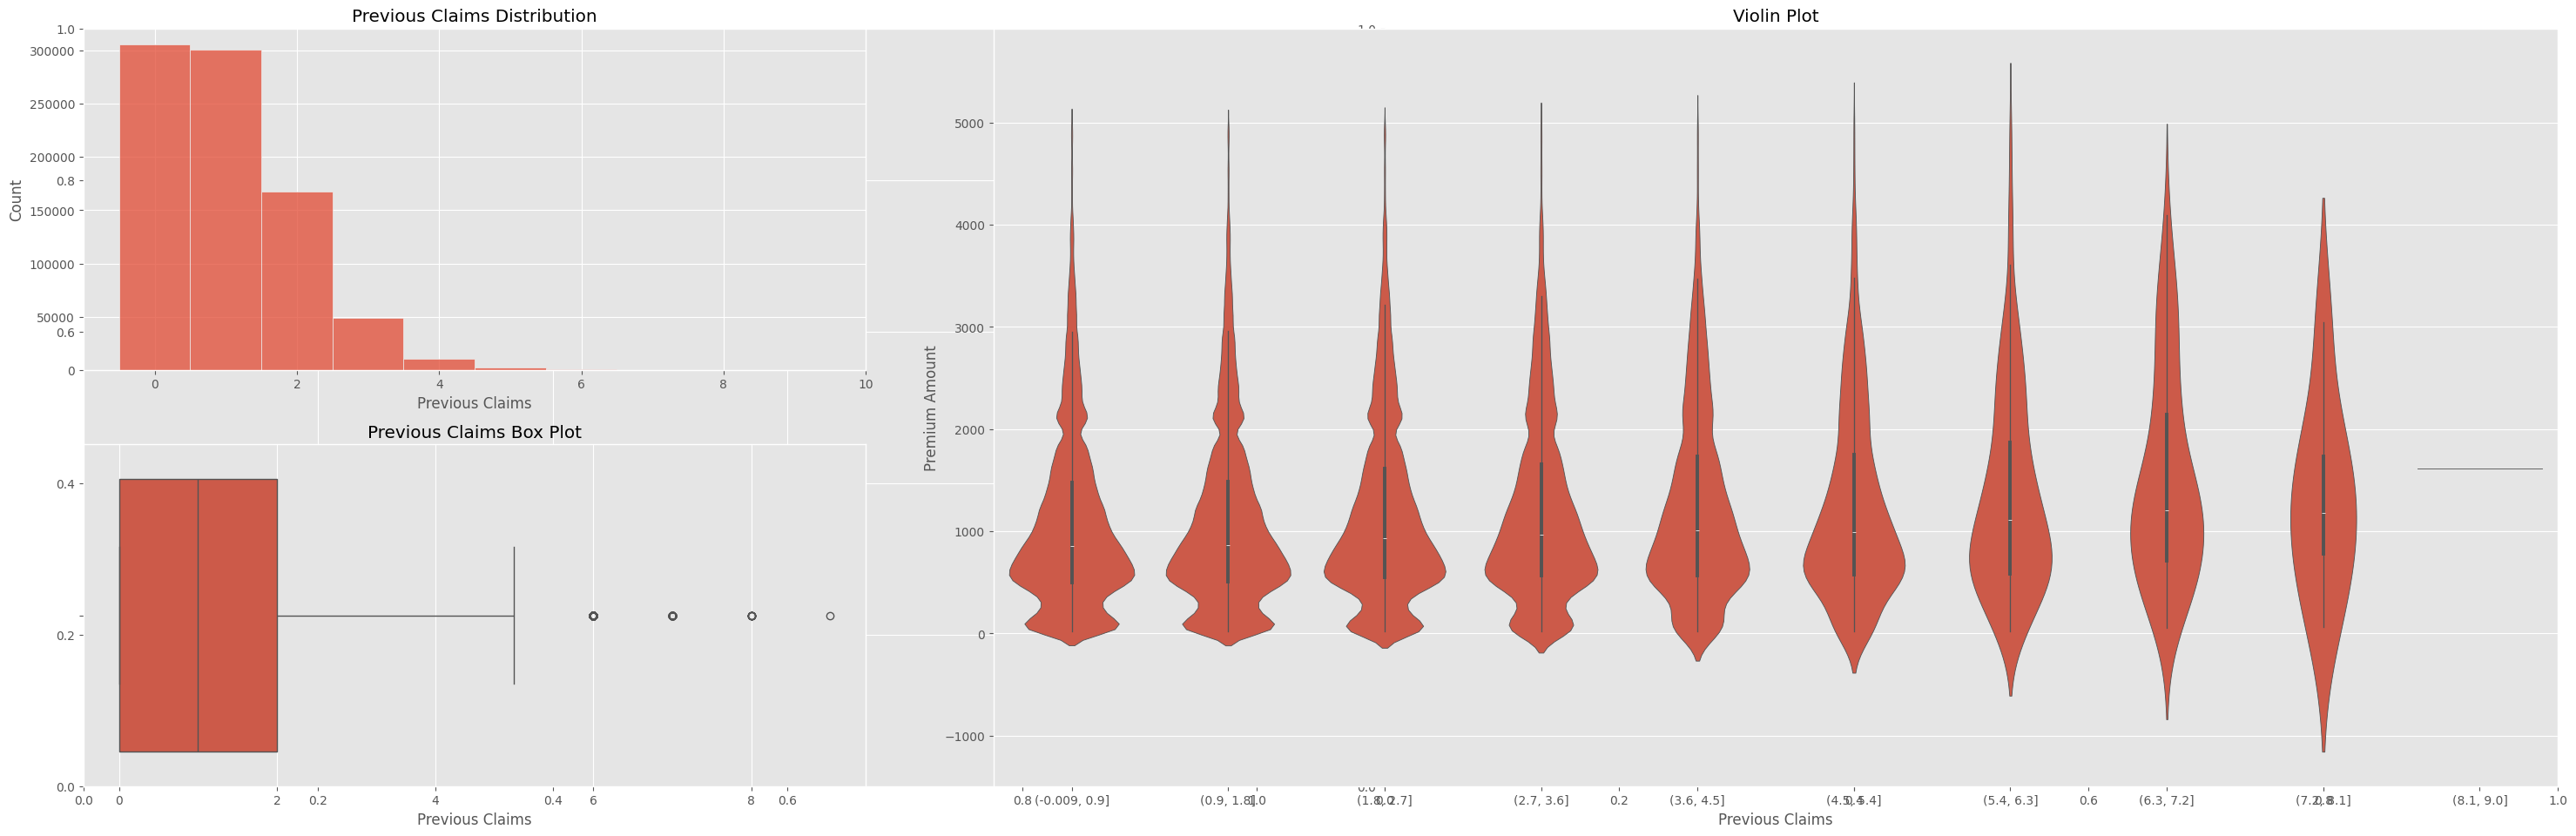

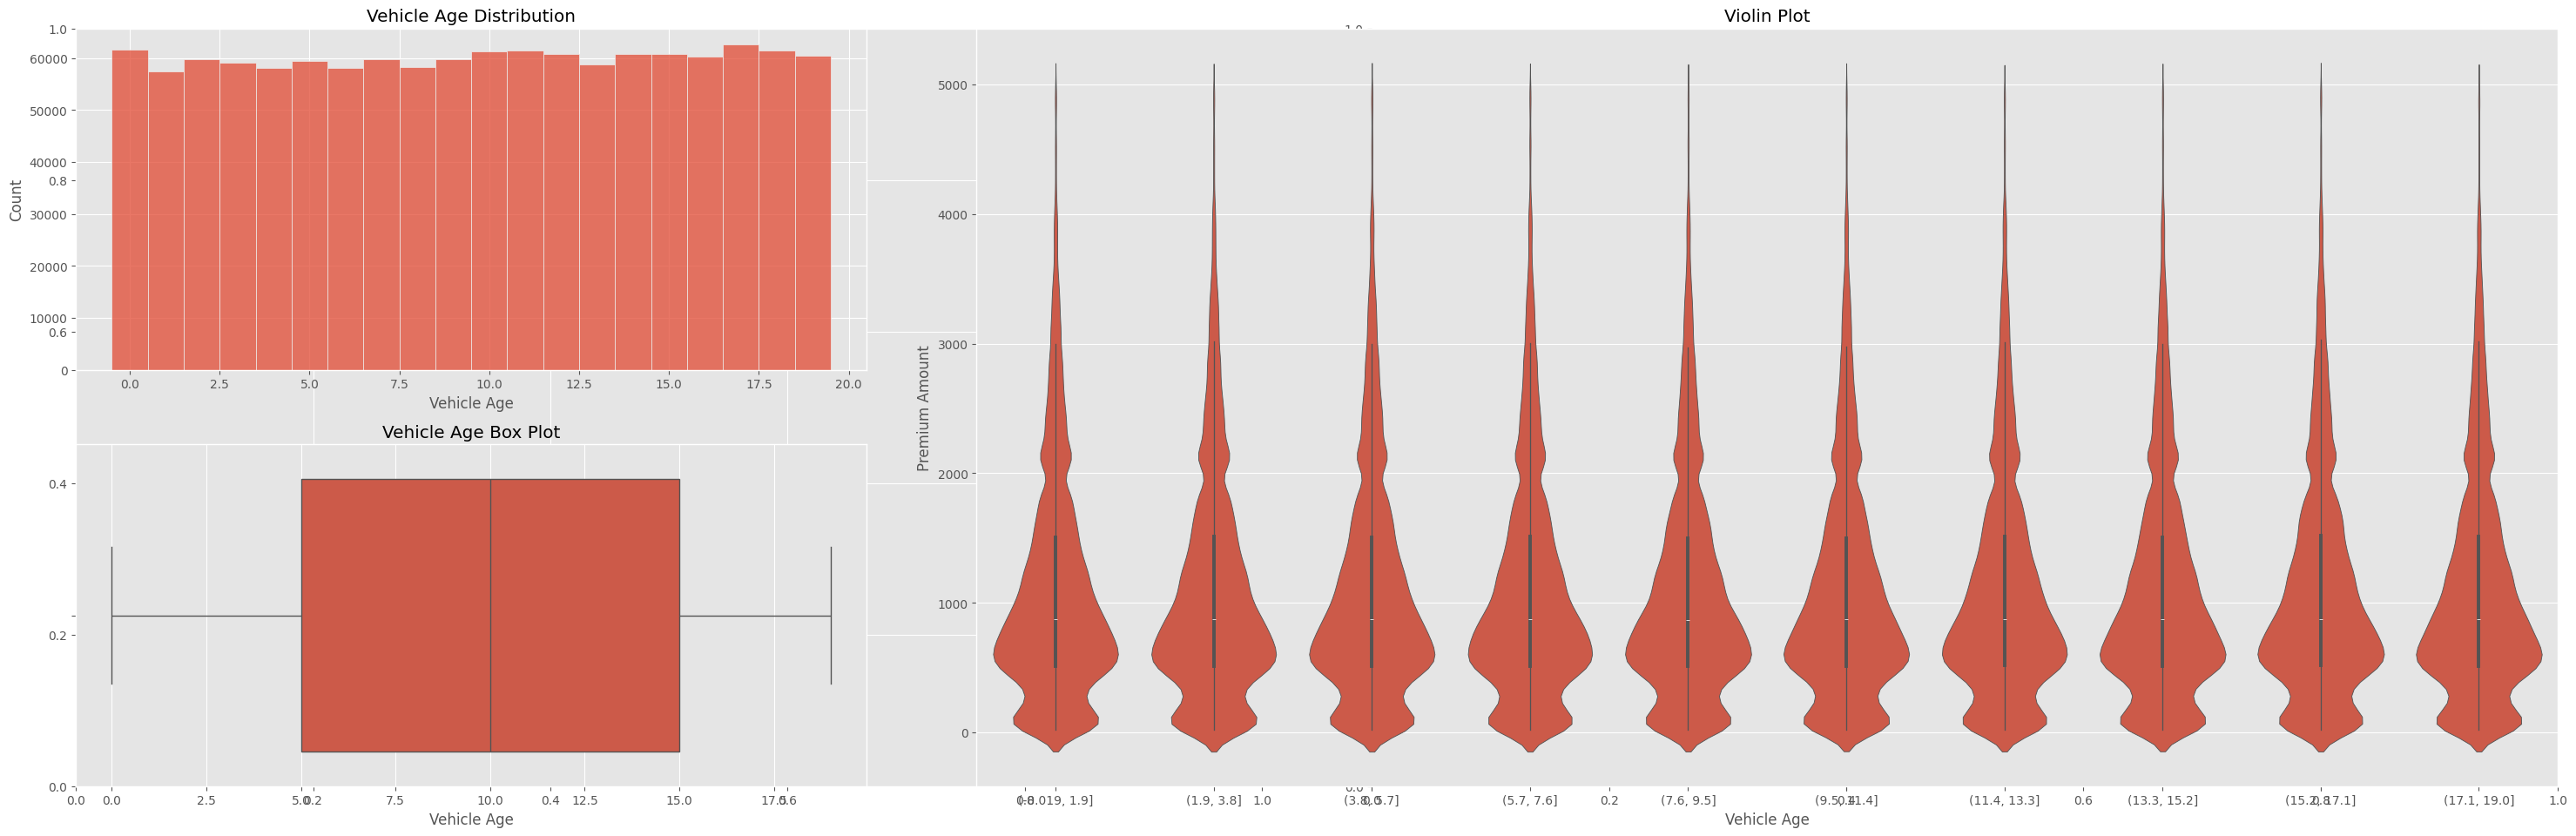

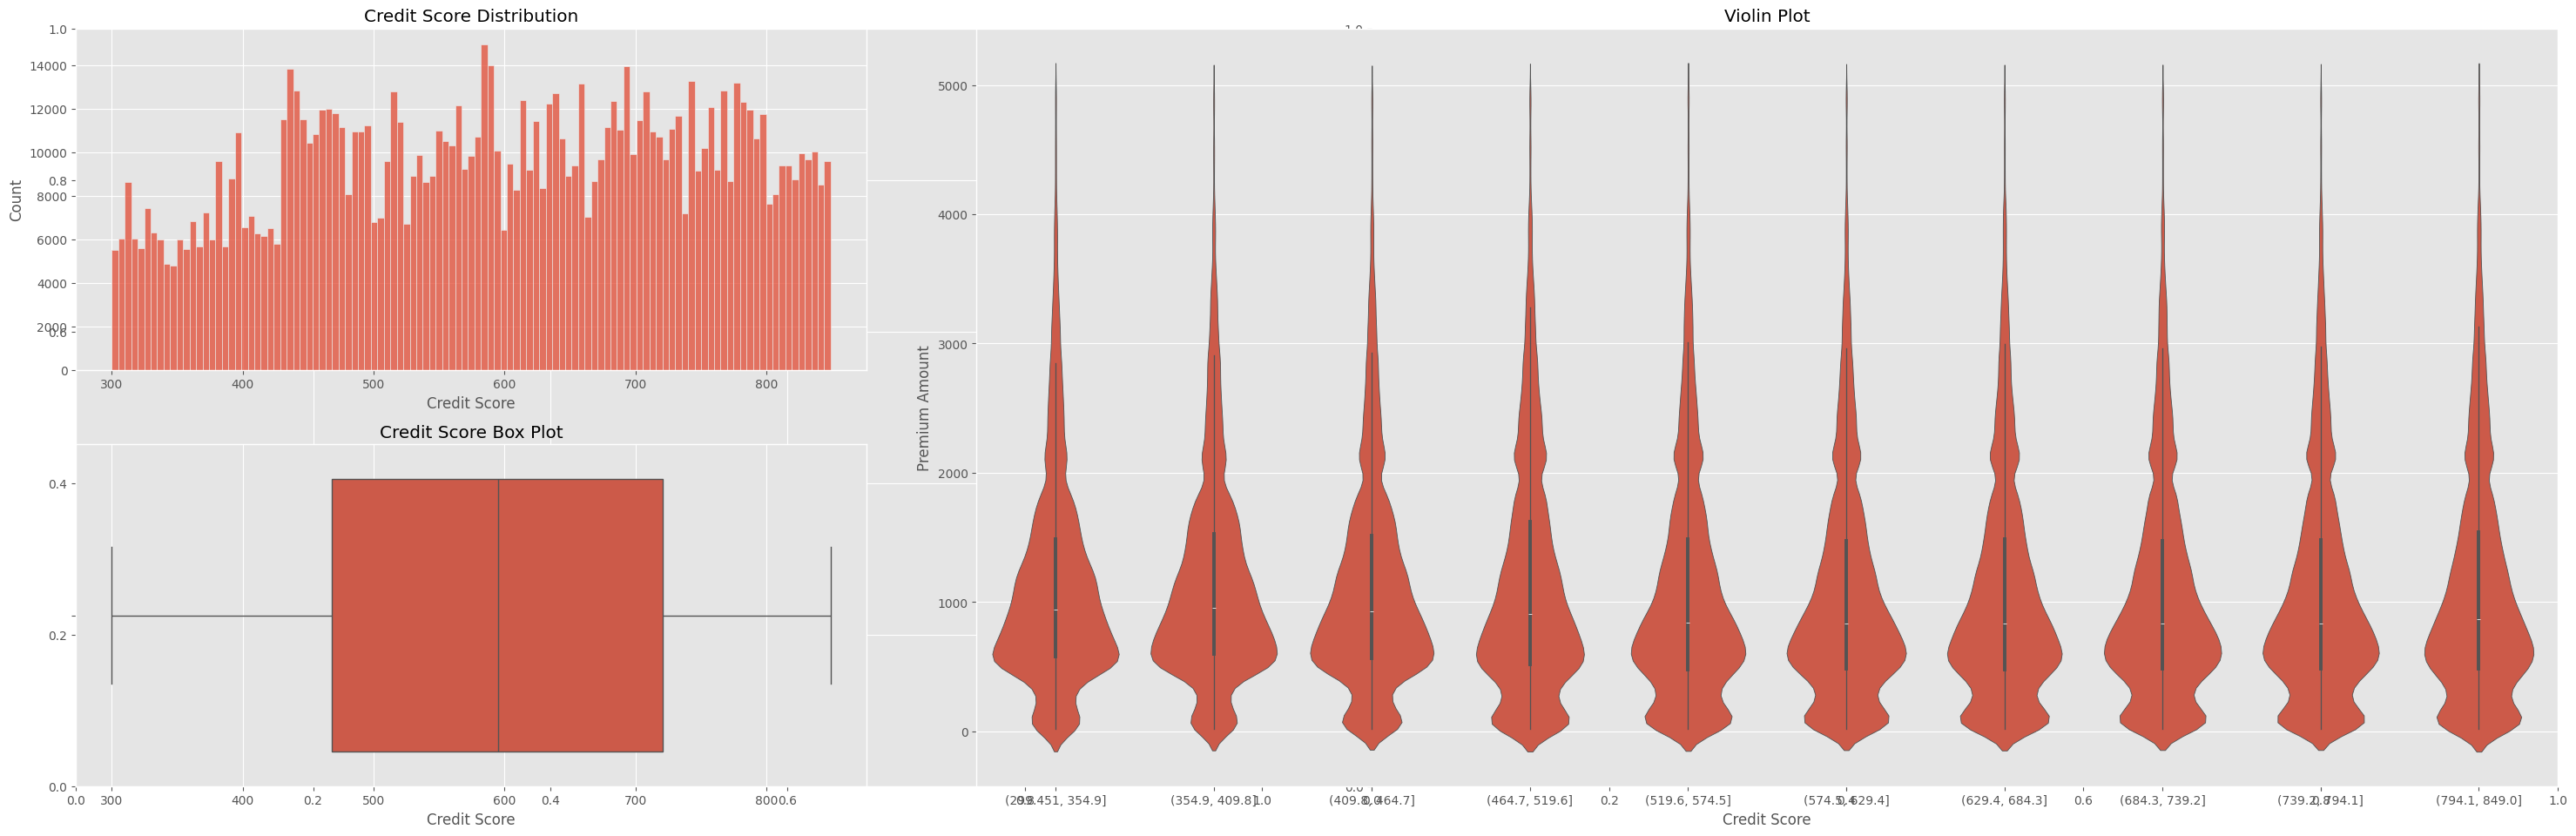

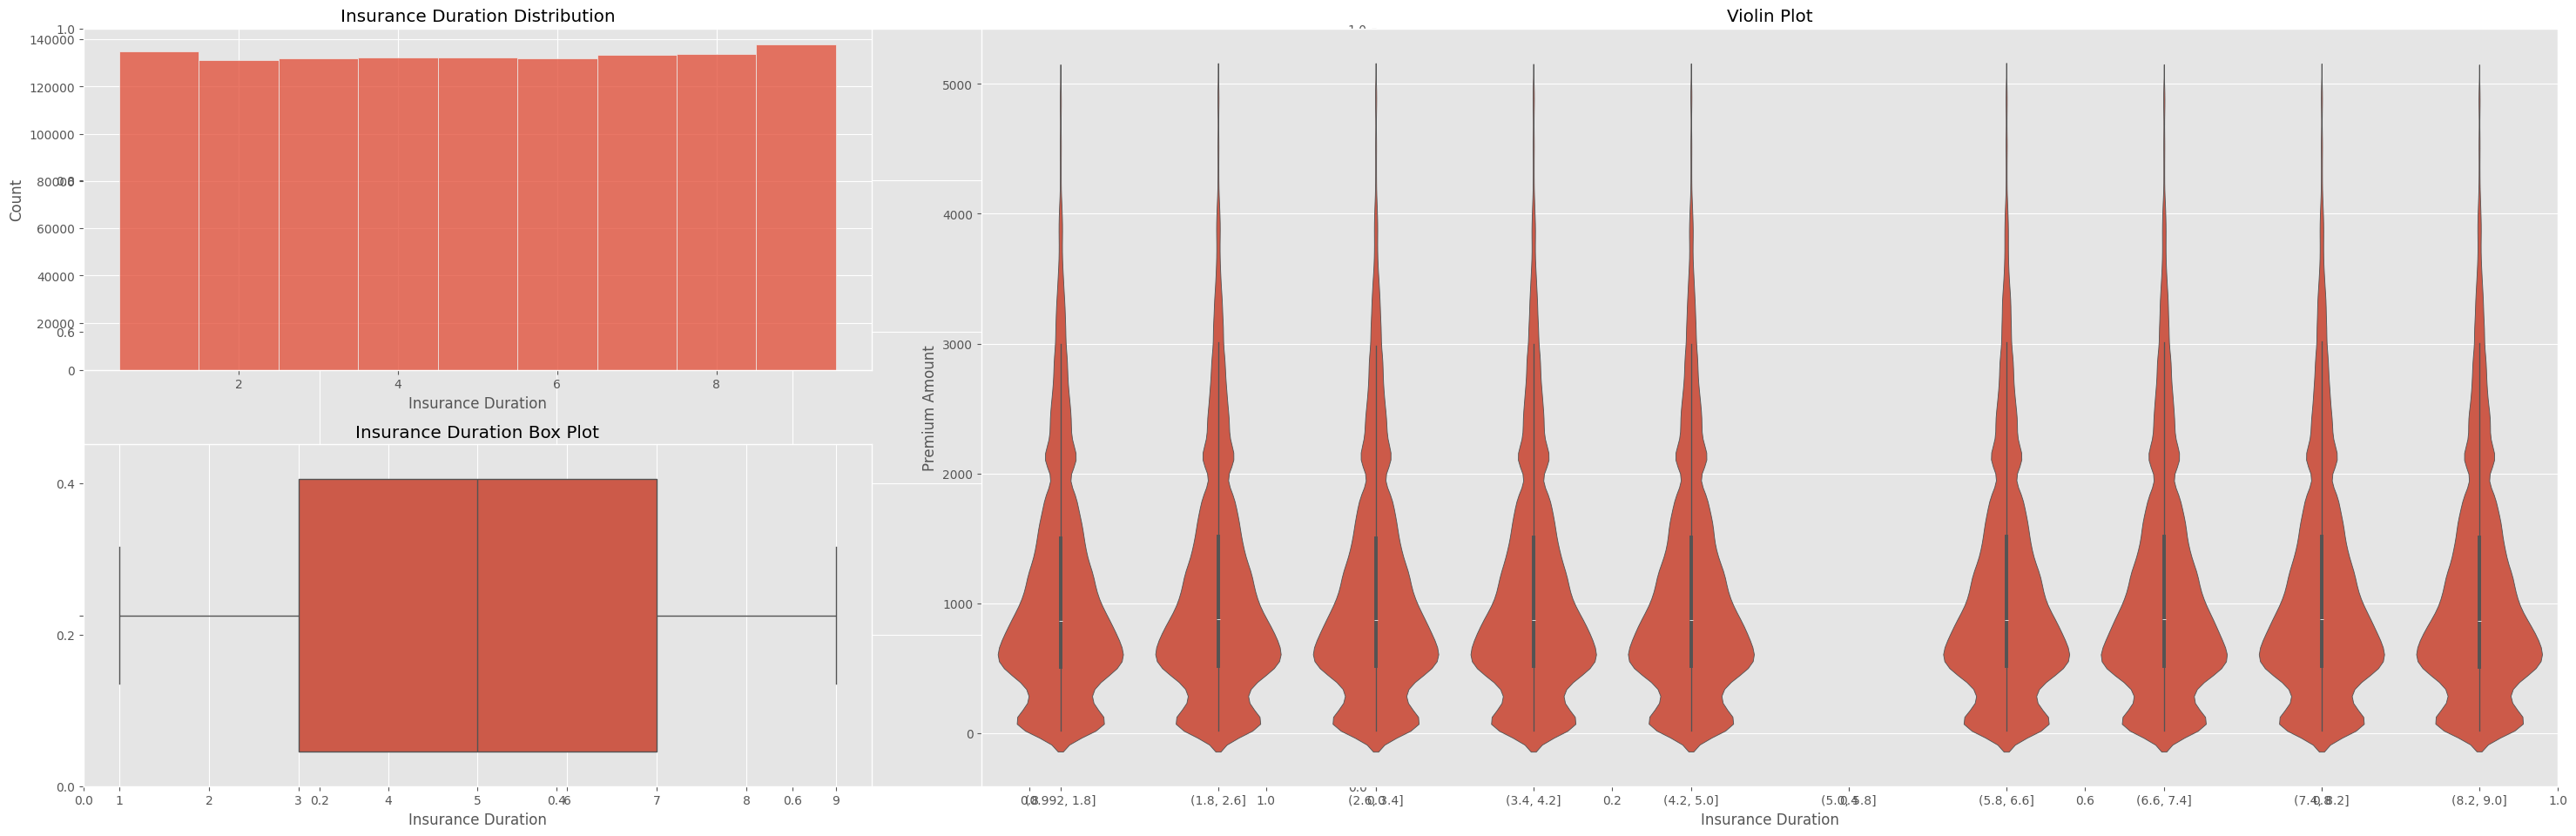

In [18]:
for col in numerical_columns:
    plot_num_col(train, col)

- The **Annual Income** feature shows a **right-skewed distribution** with a wide range of values and numerous **outliers**.  
- To address **skewness** and **reduce the impact of outliers**, a **log transformation** will be applied for normalization.

In [19]:
def plot_cat_col(df, col):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))

    sns.countplot(data=df, x=col, ax=ax[0], hue=col)
    ax[0].set_title(f'{col} Distribution')
    ax[0].set_xlabel(f'{col}')
    ax[0].set_ylabel('Count')
    
    sns.boxplot(data=df, x=col, y='Premium Amount', ax=ax[1], hue=col)
    ax[1].set_title(f'{col} Boxplot')
    ax[1].set_xlabel(f'{col}')

    plt.tight_layout()
    plt.show()

In [20]:
category_columns = [col for col in object_columns if col != 'Policy Start Date']

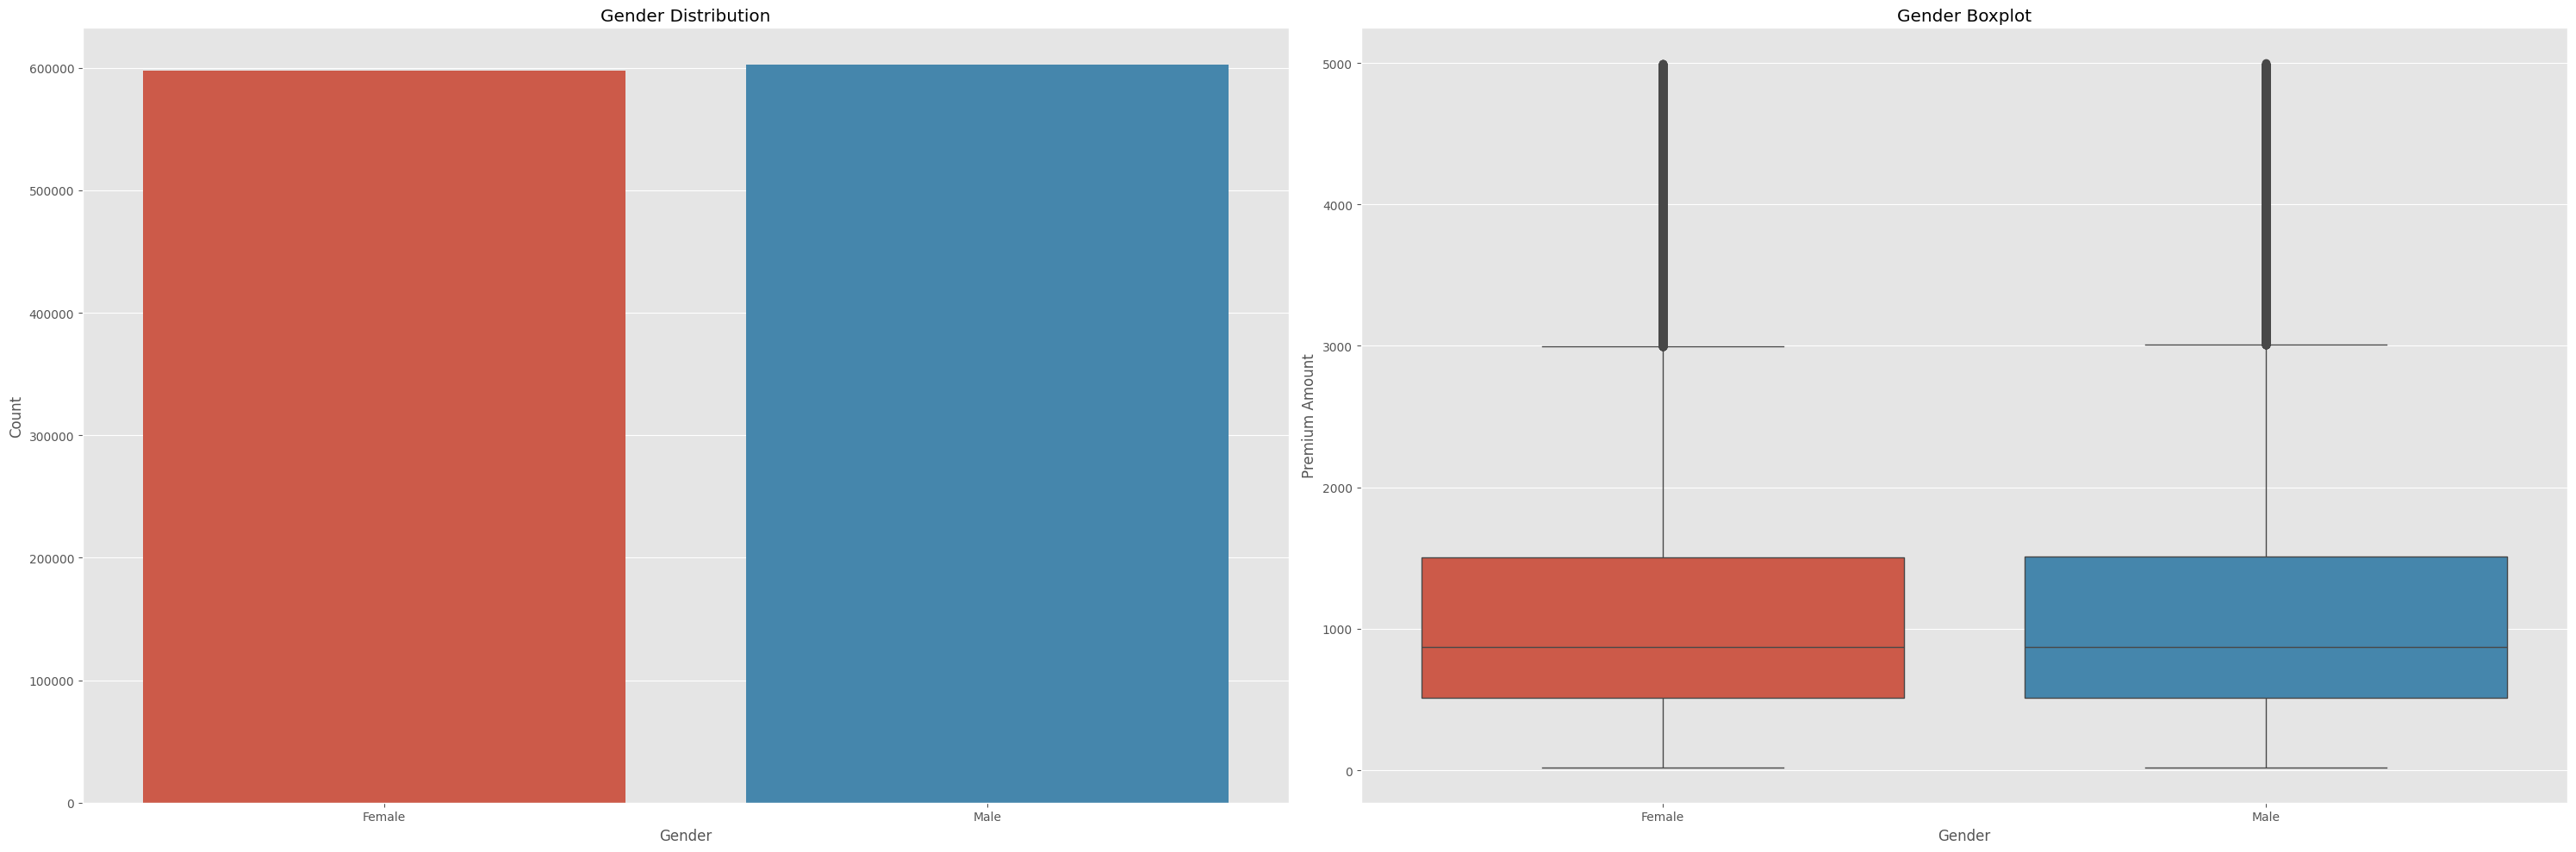

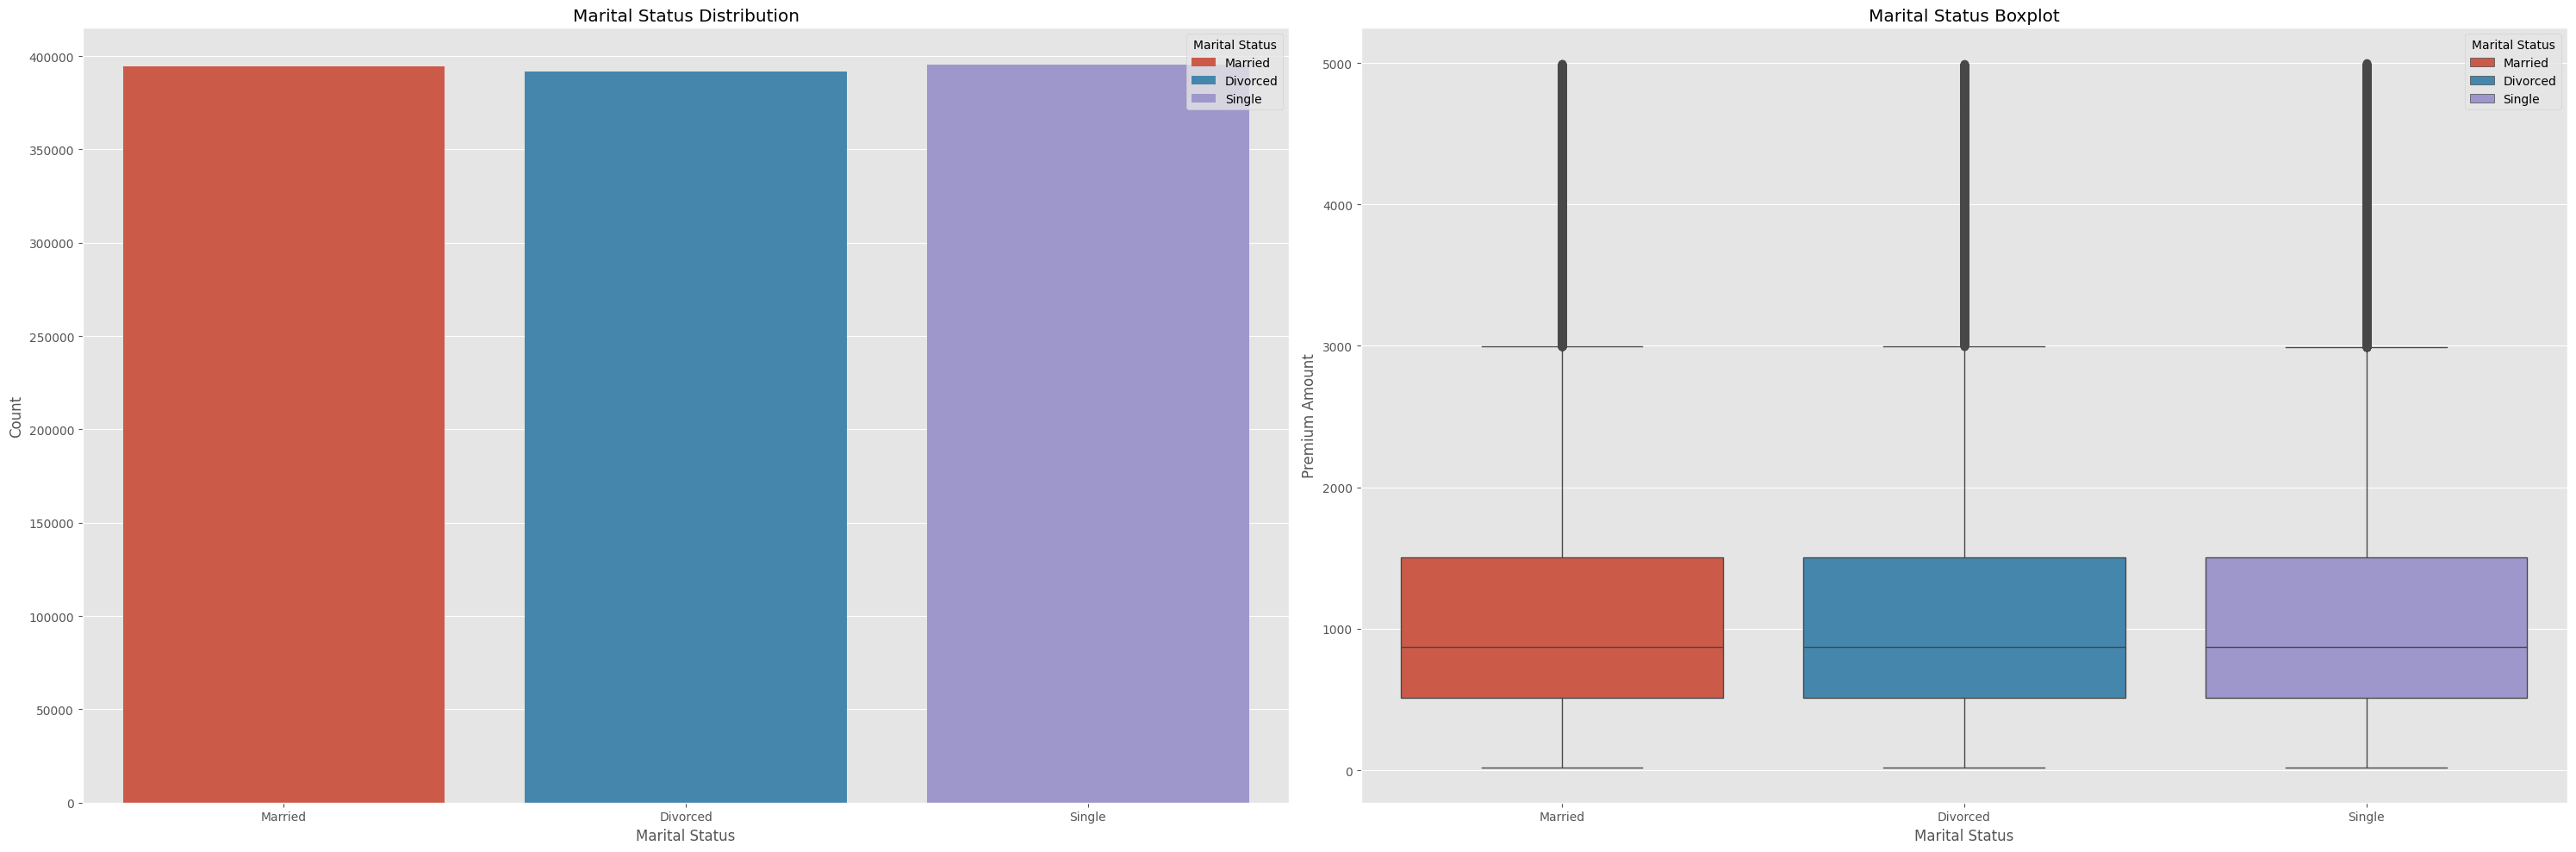

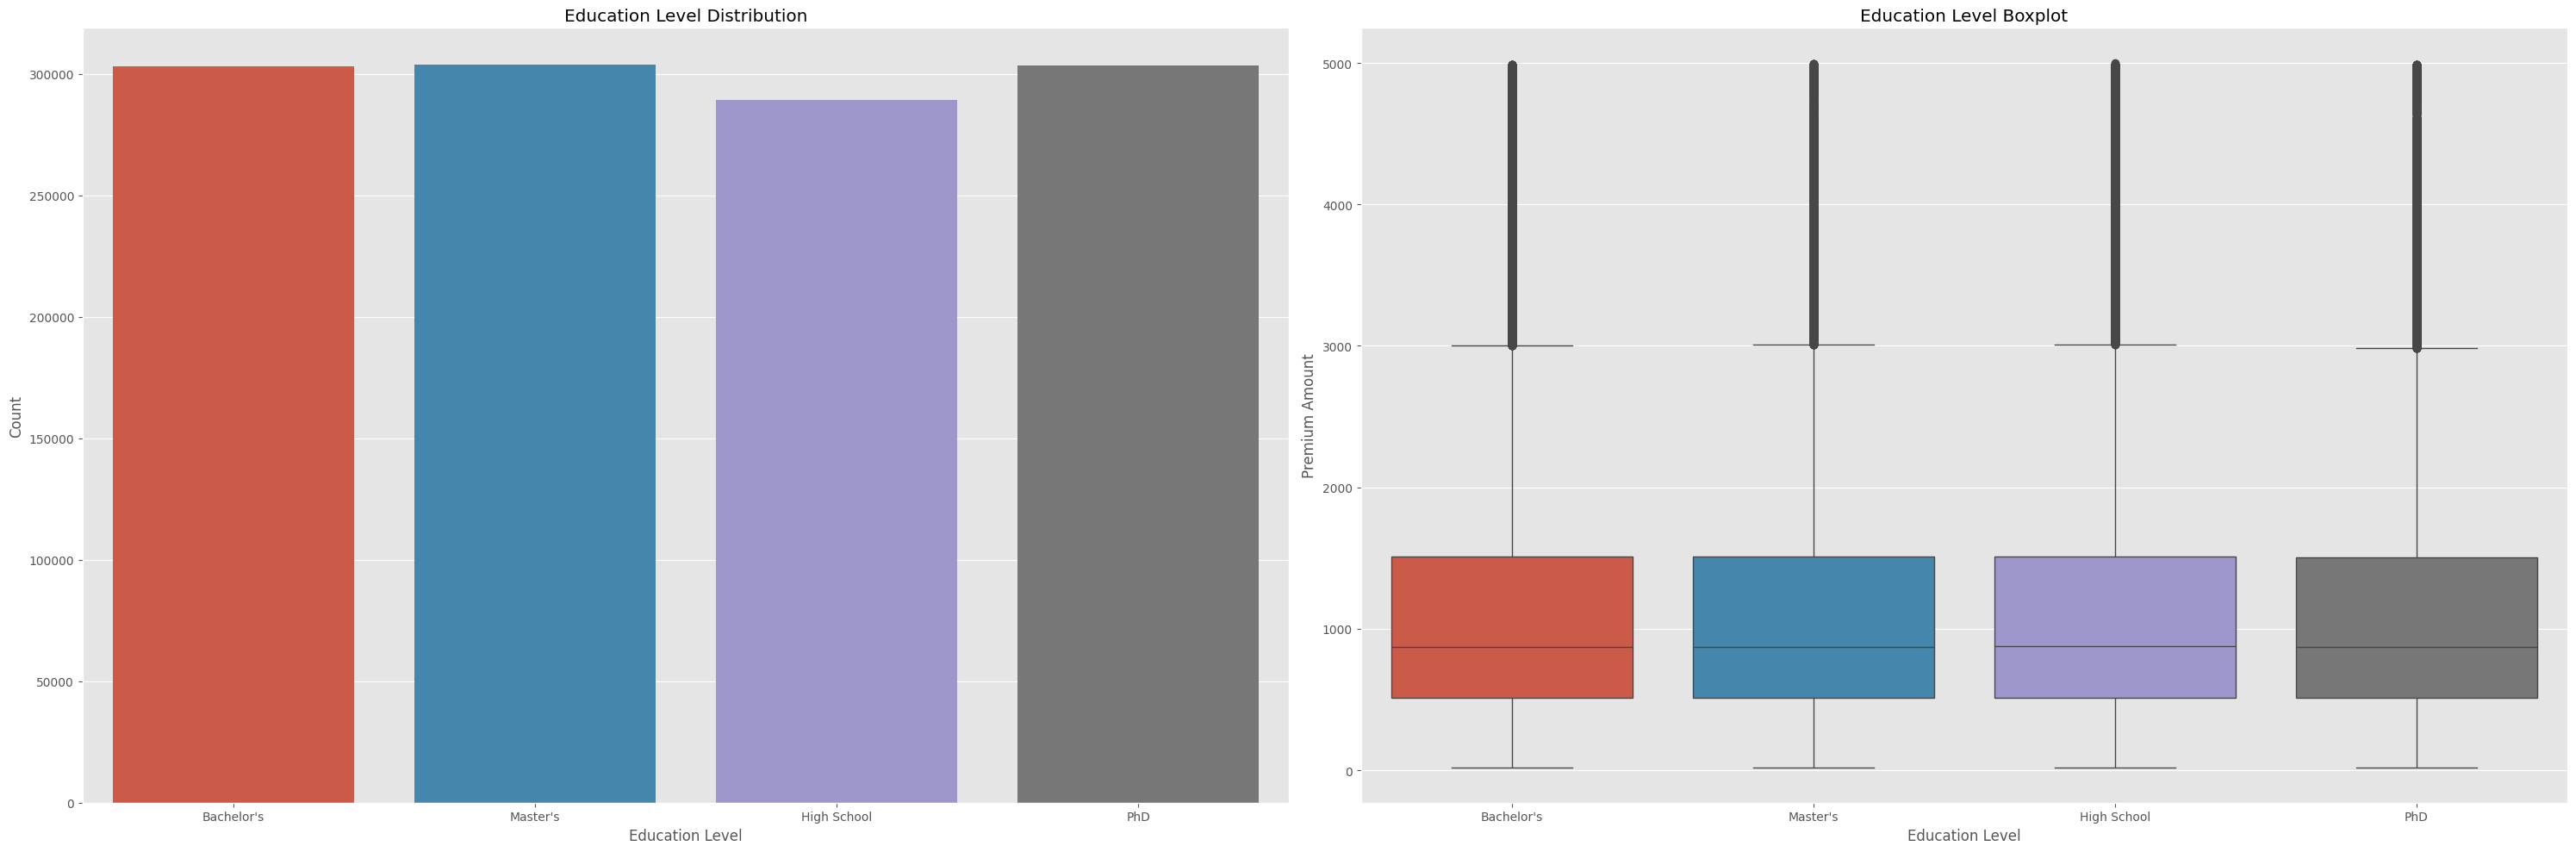

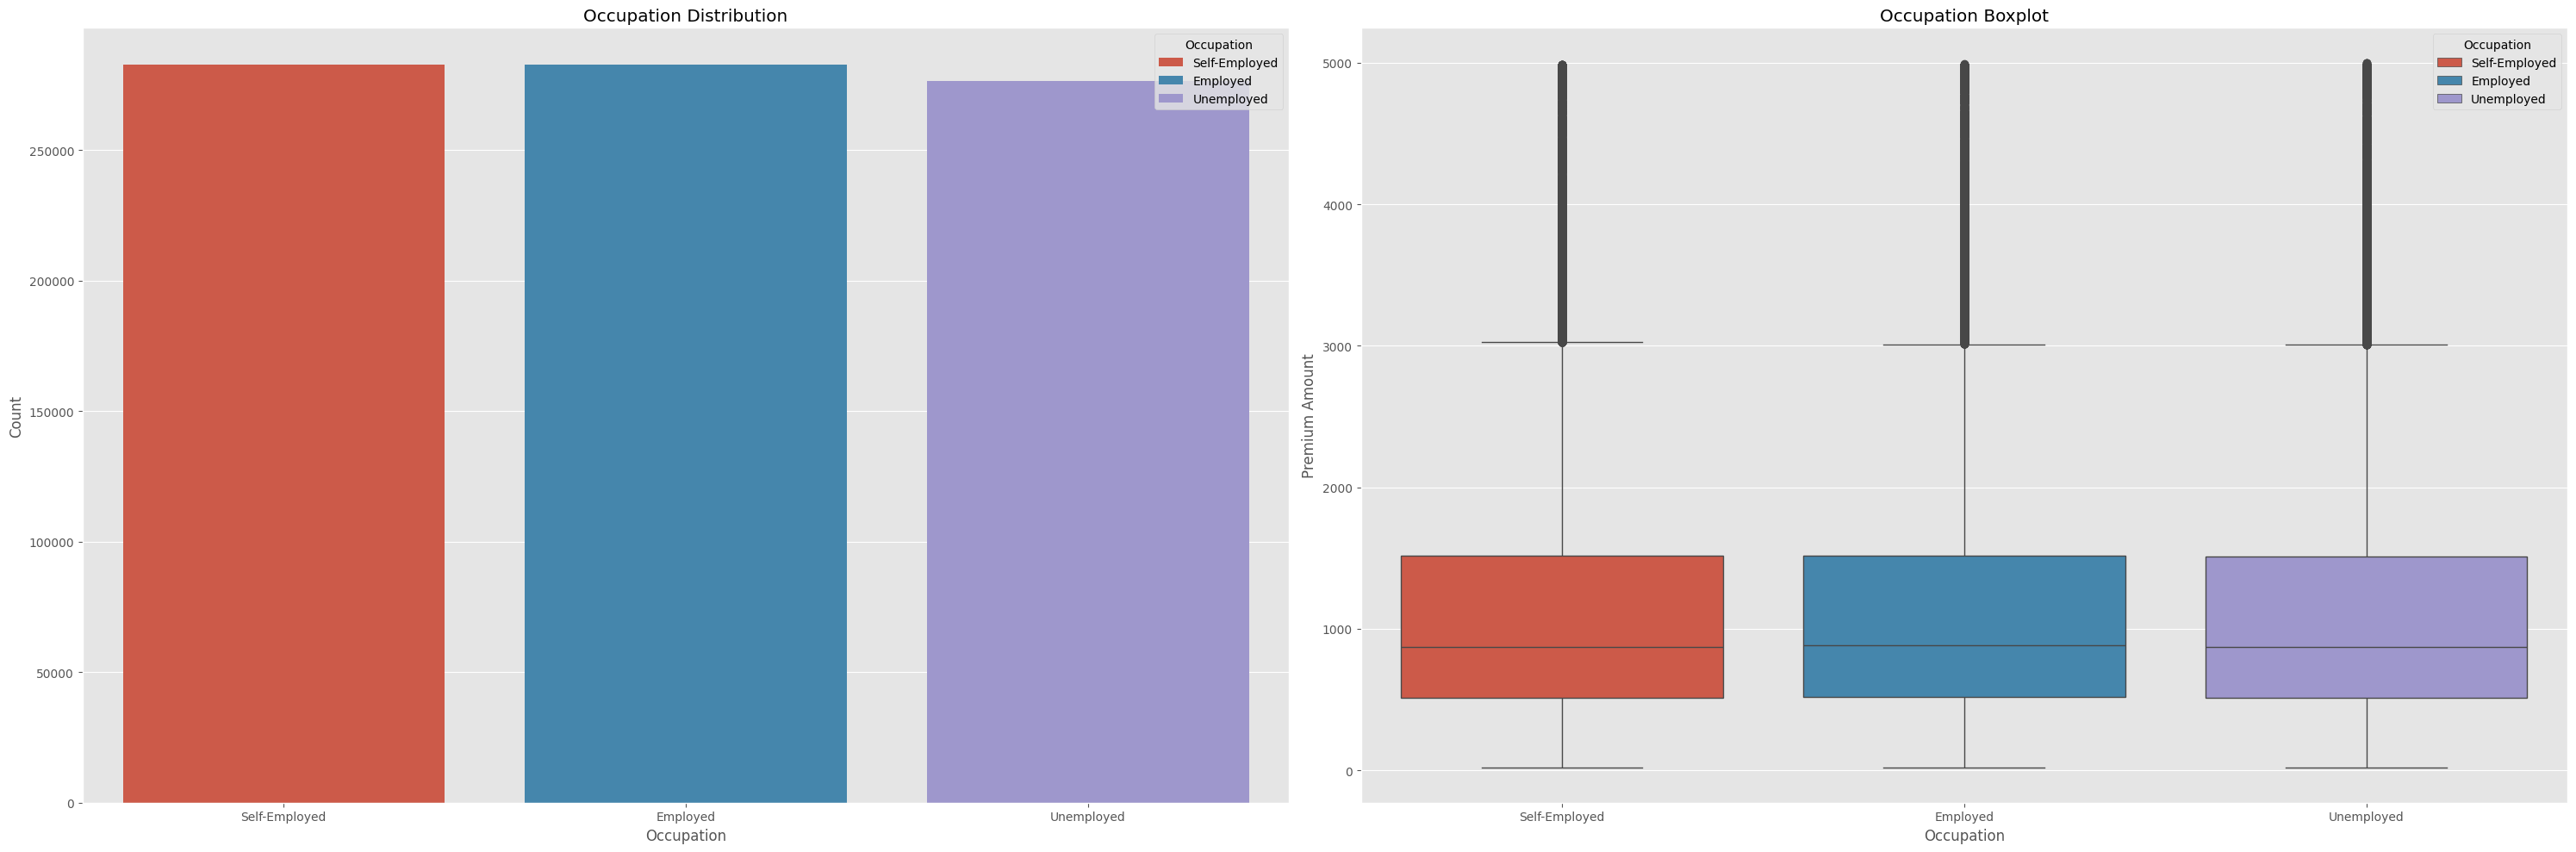

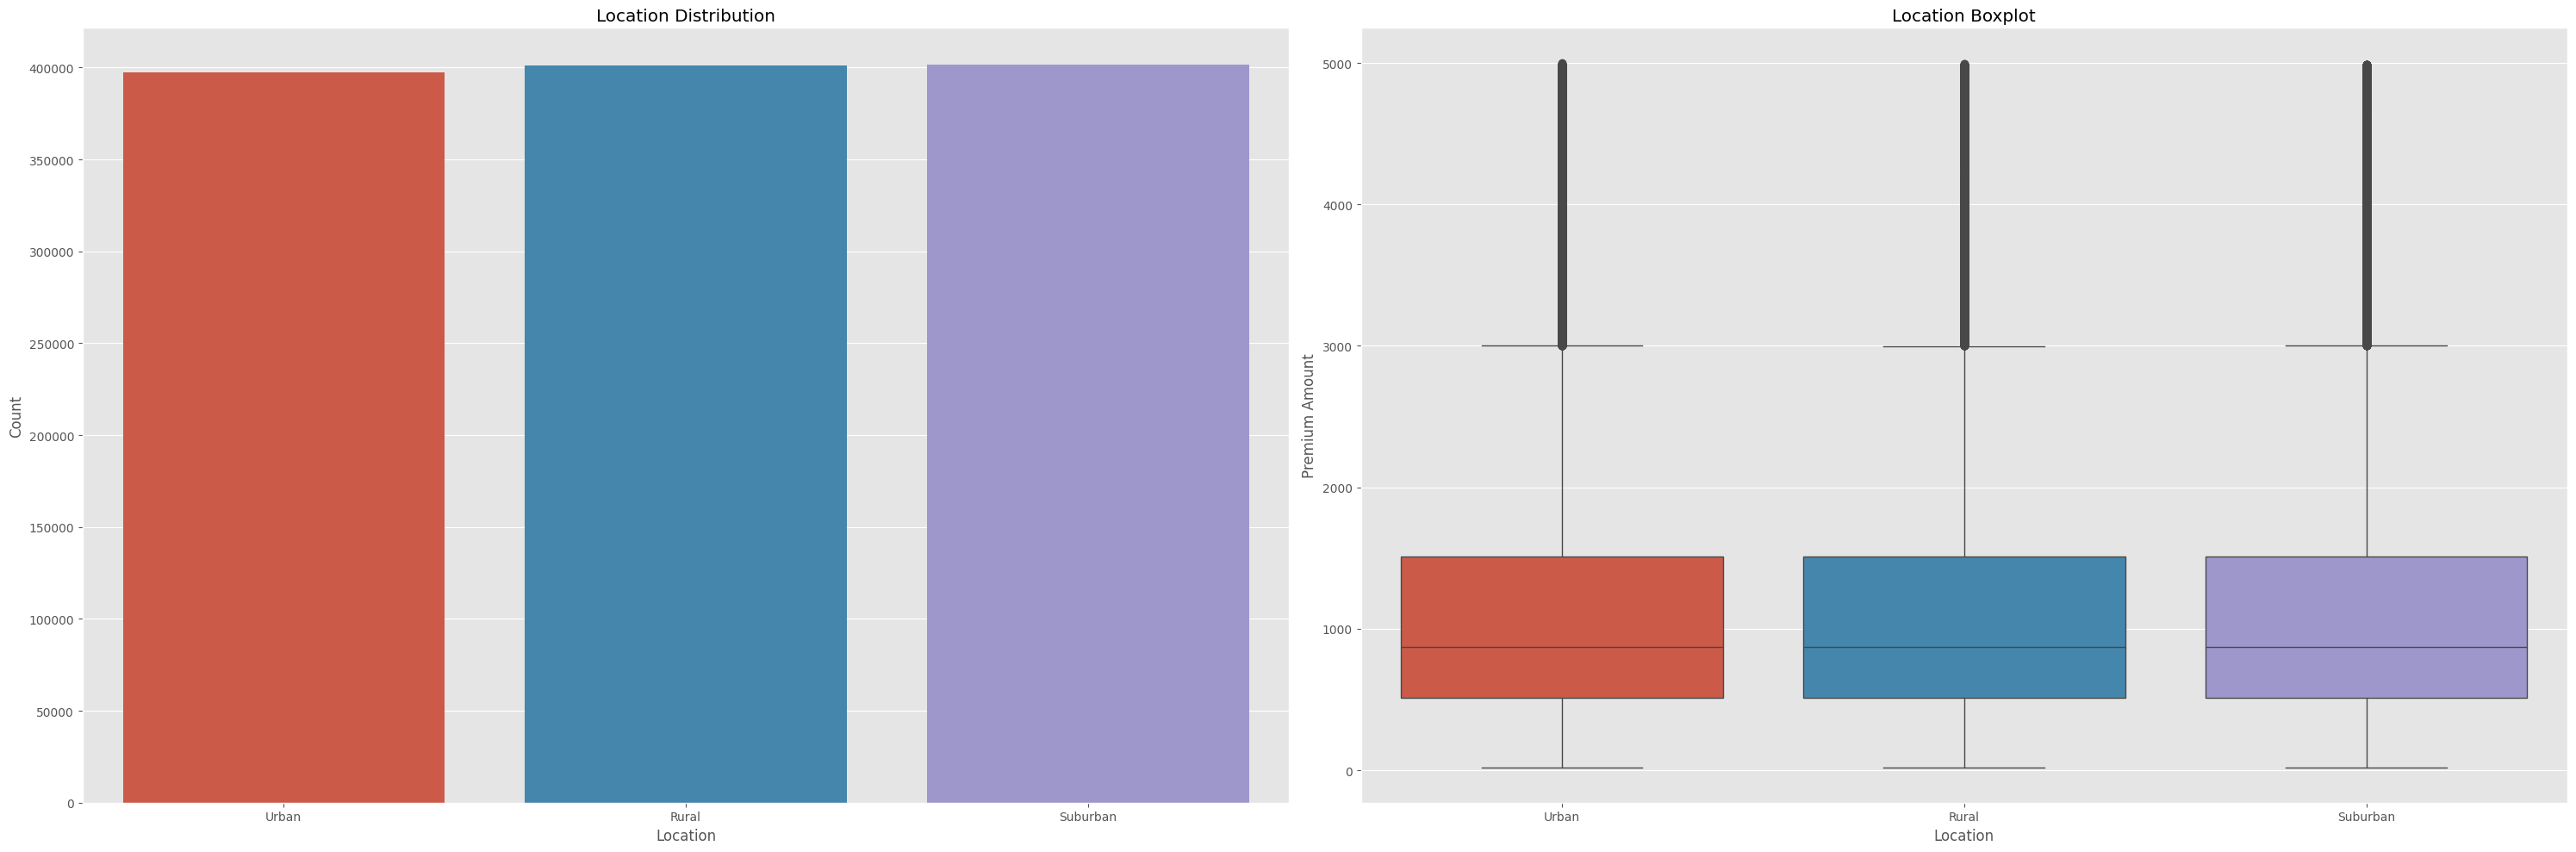

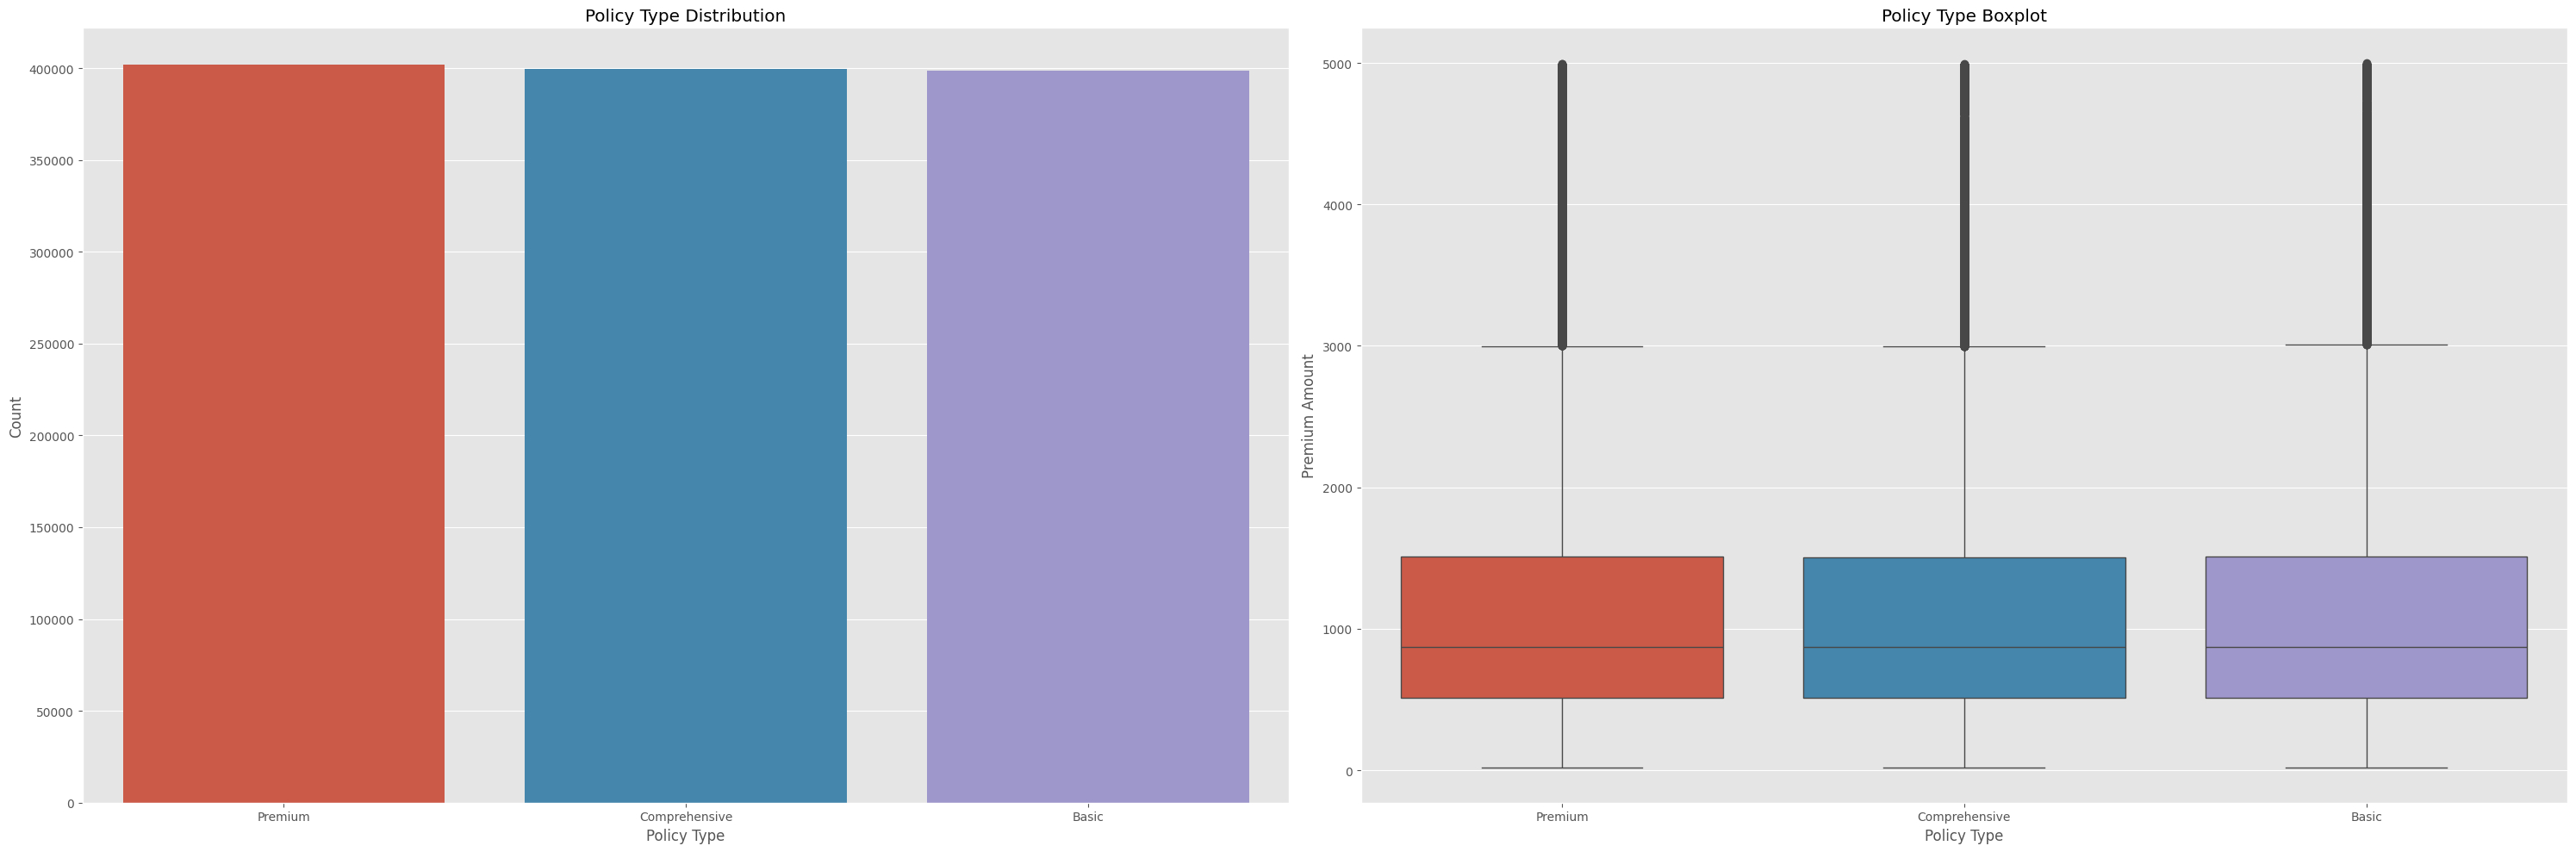

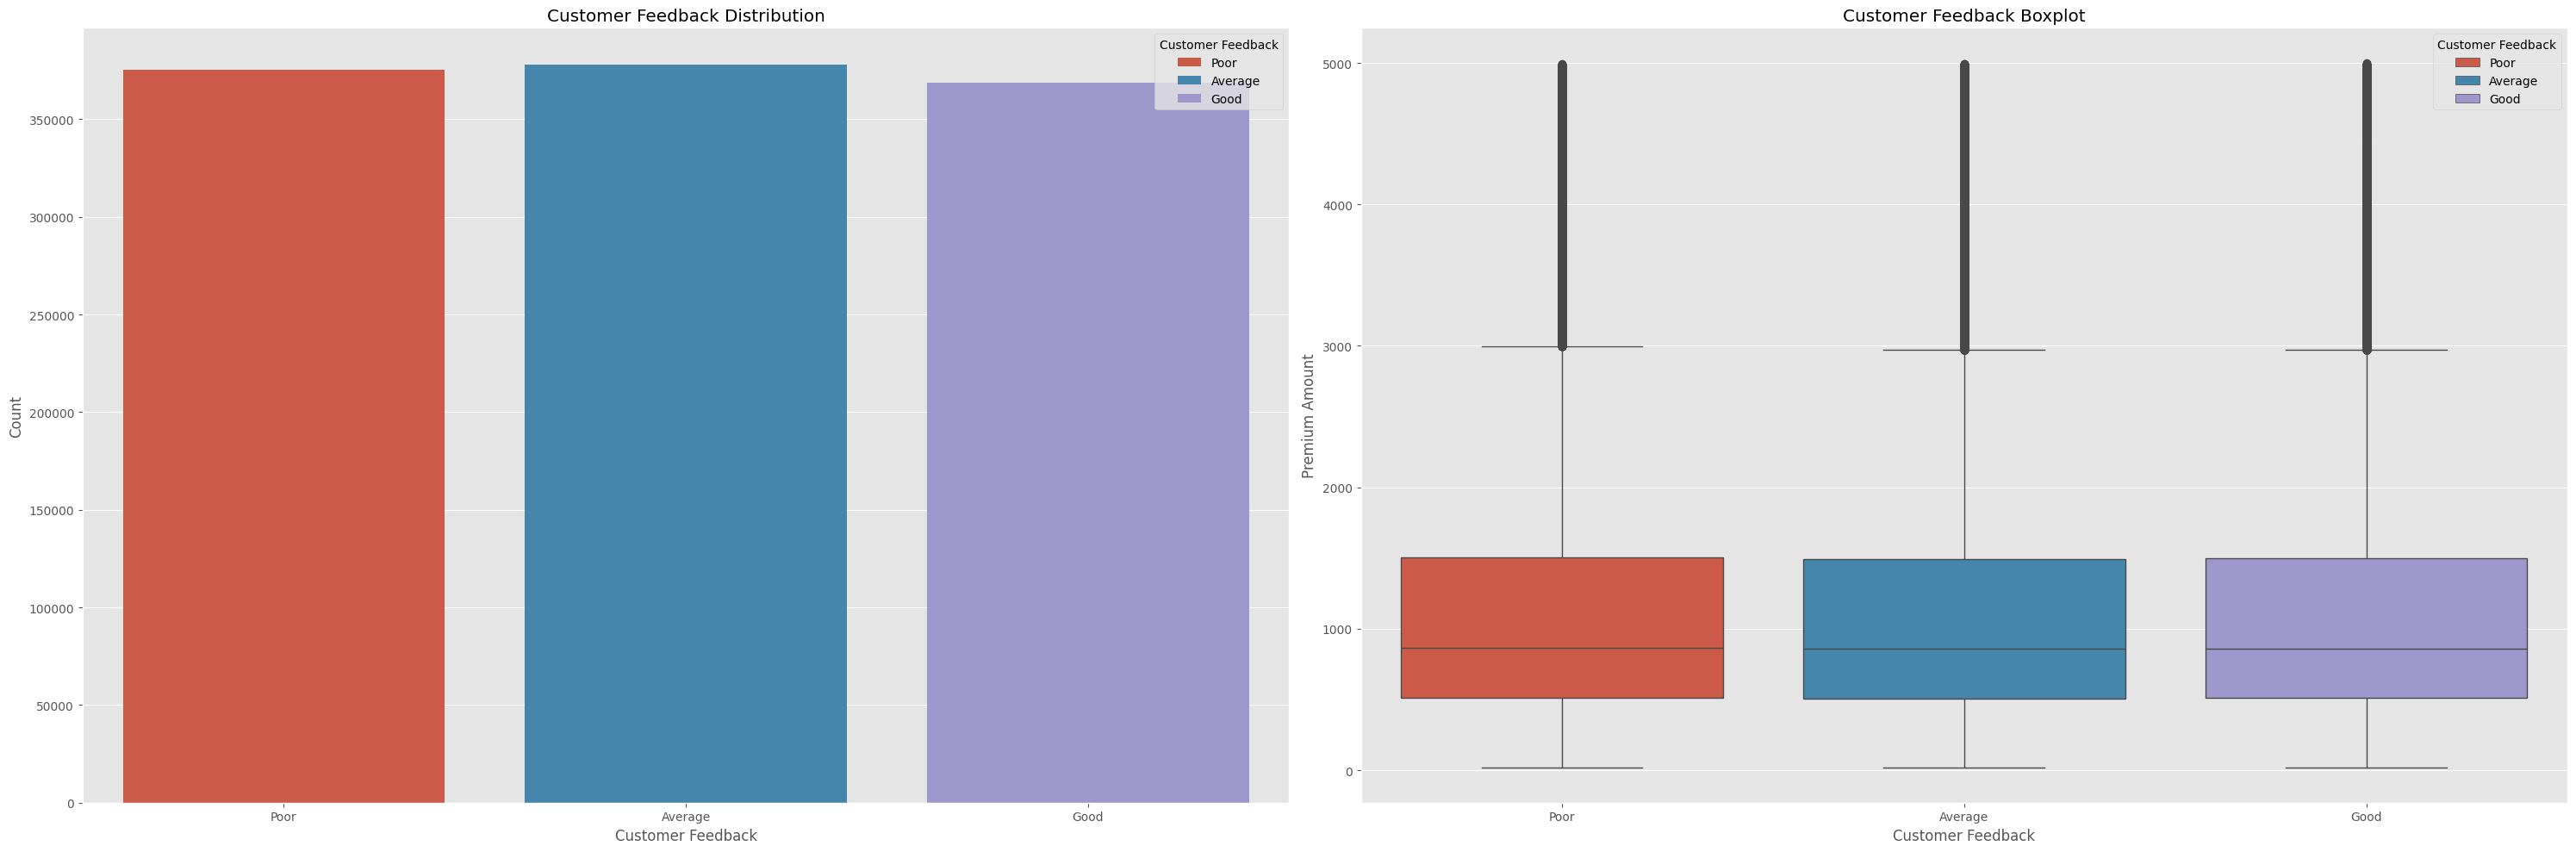

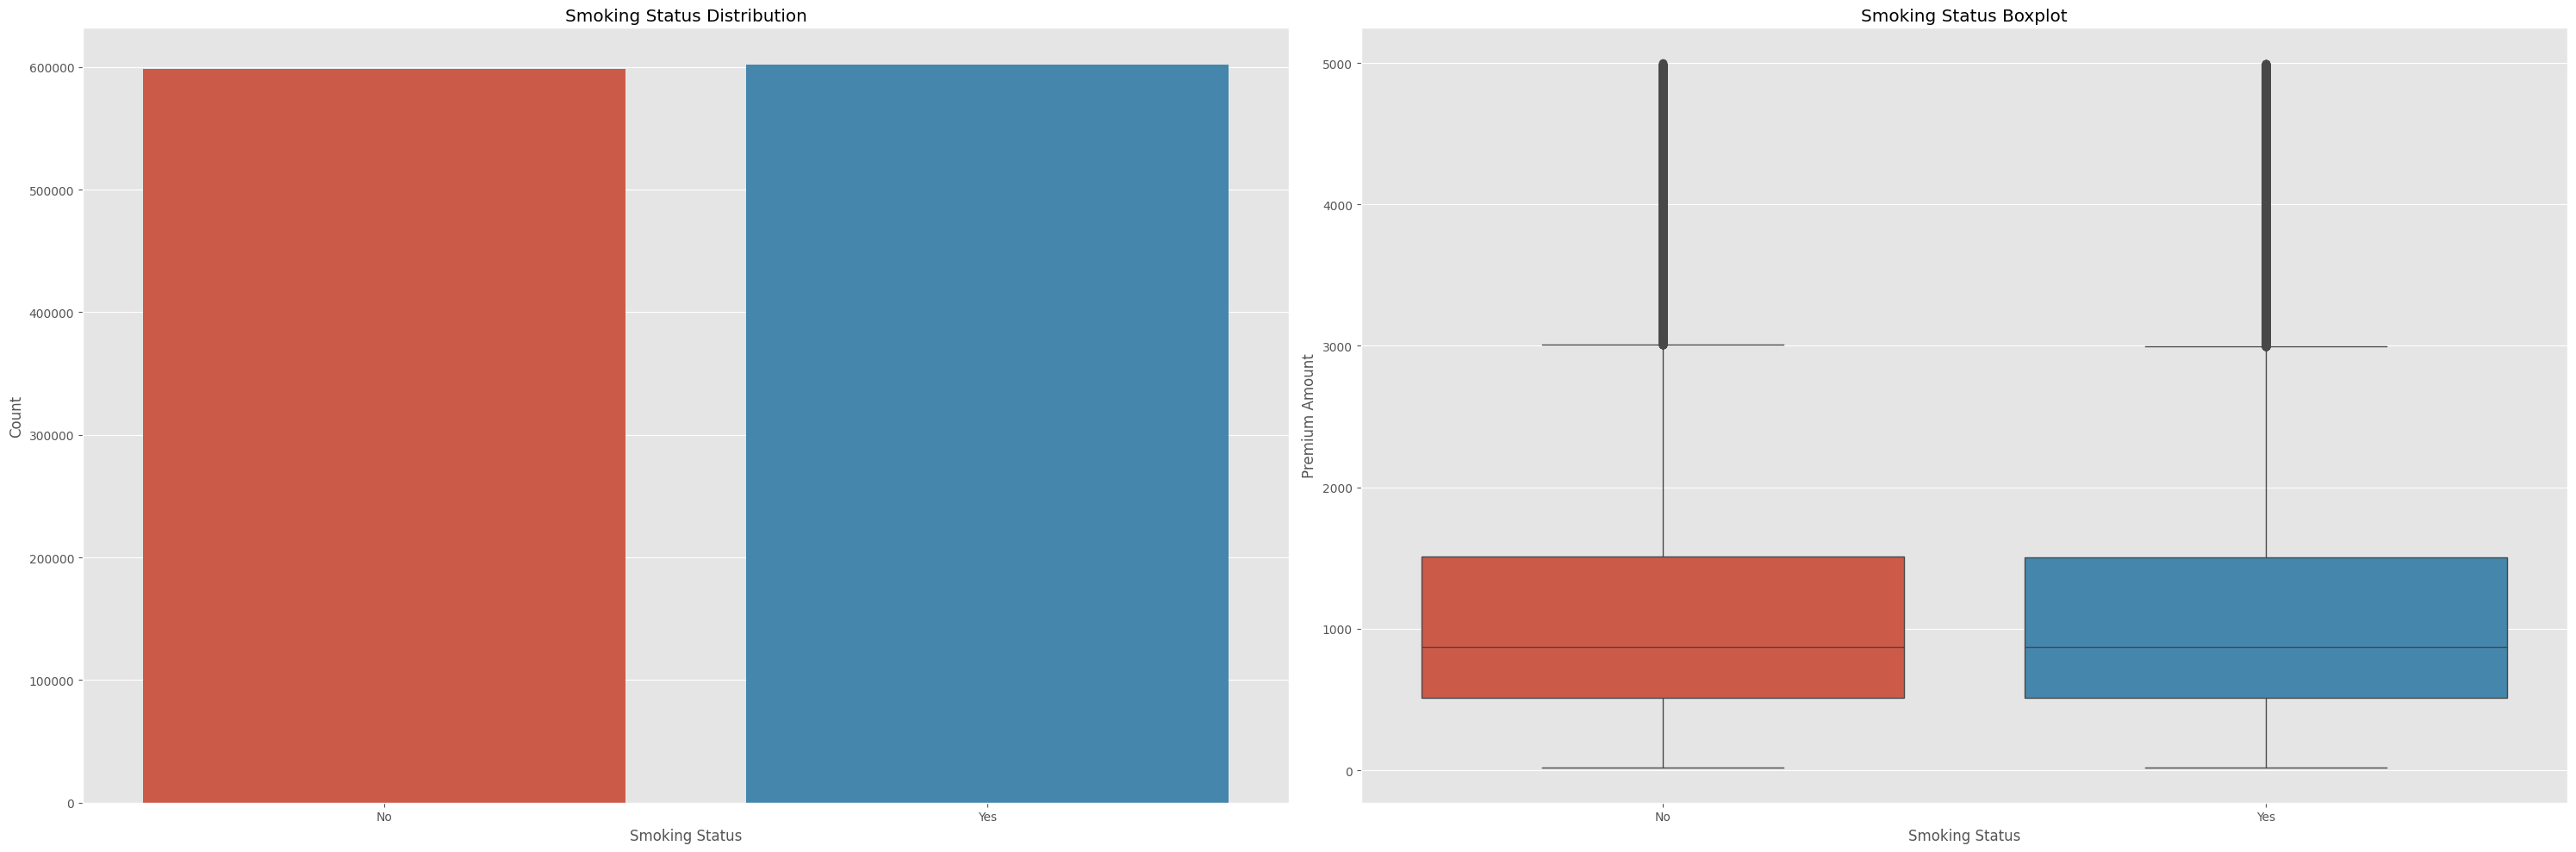

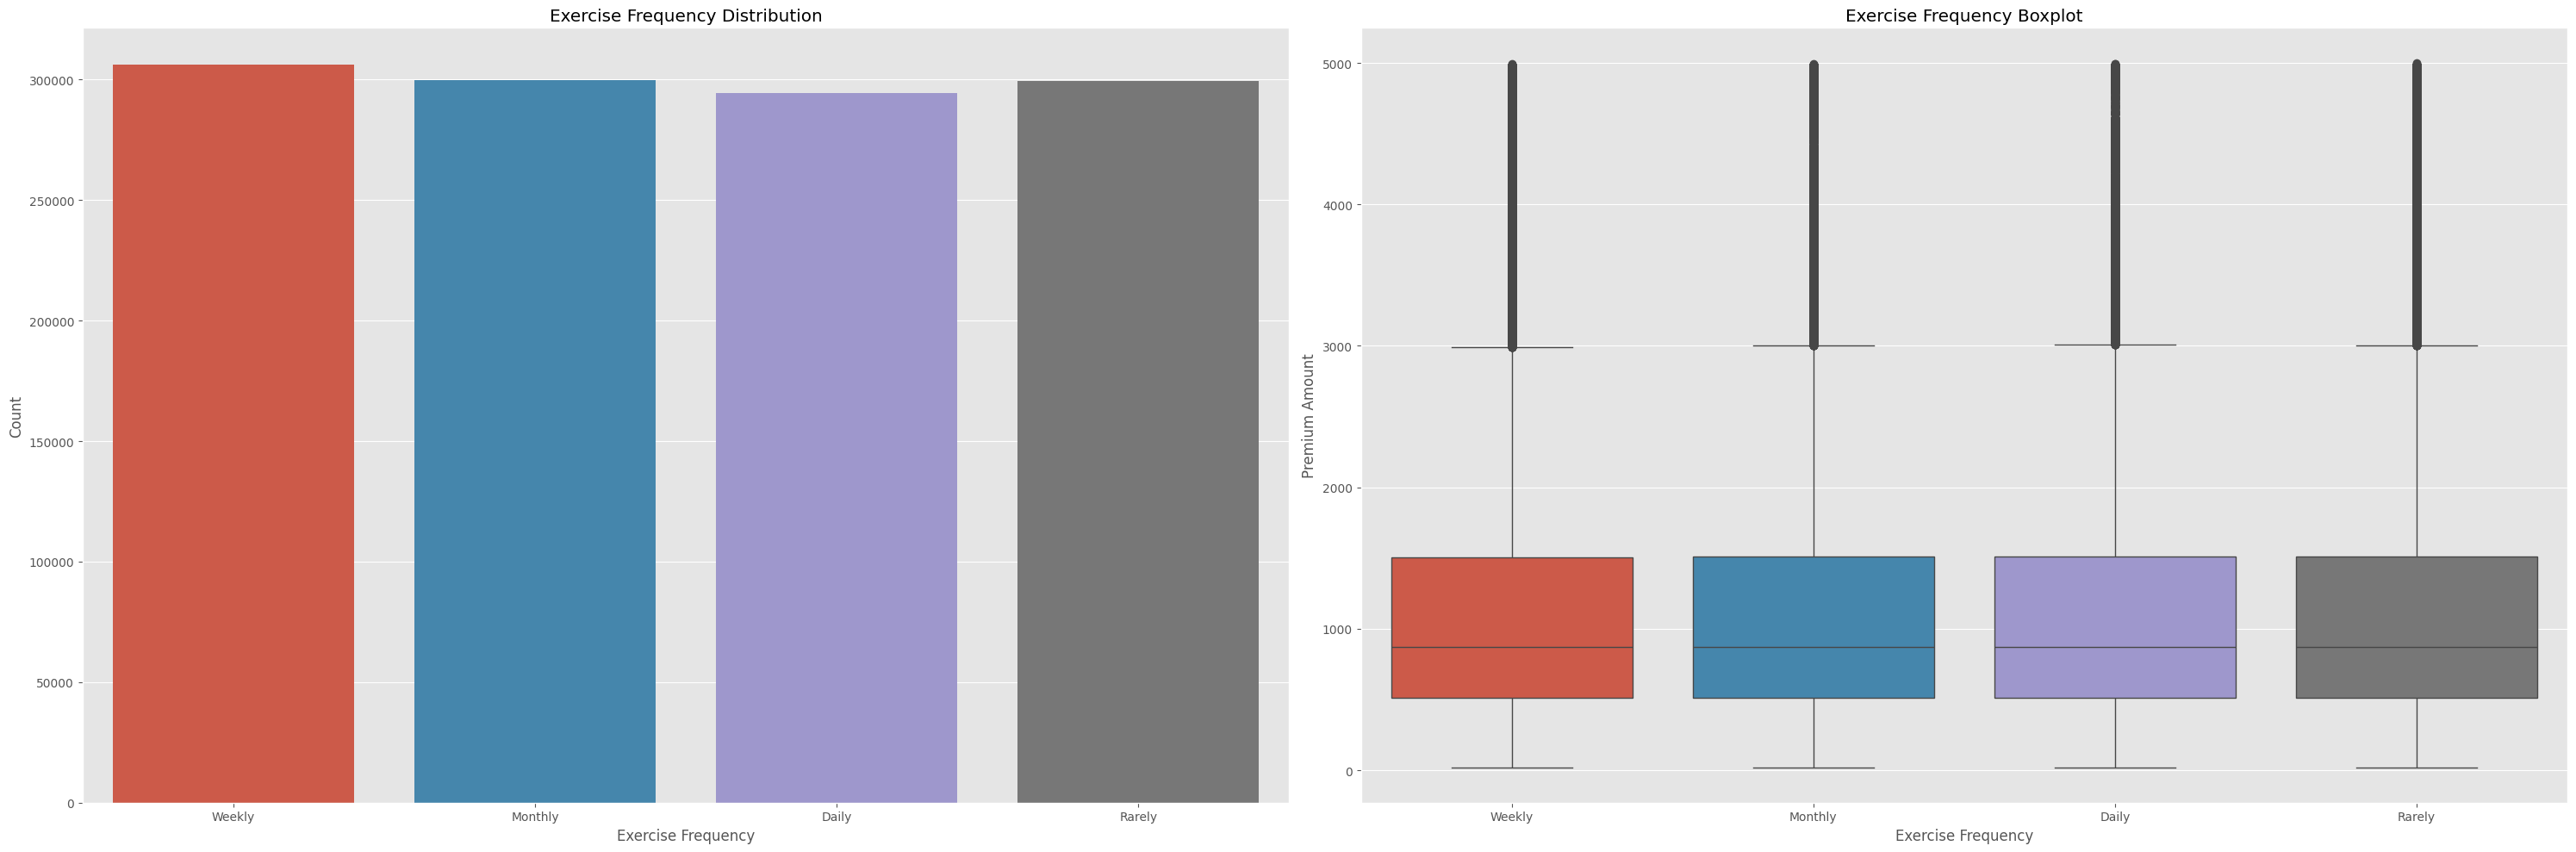

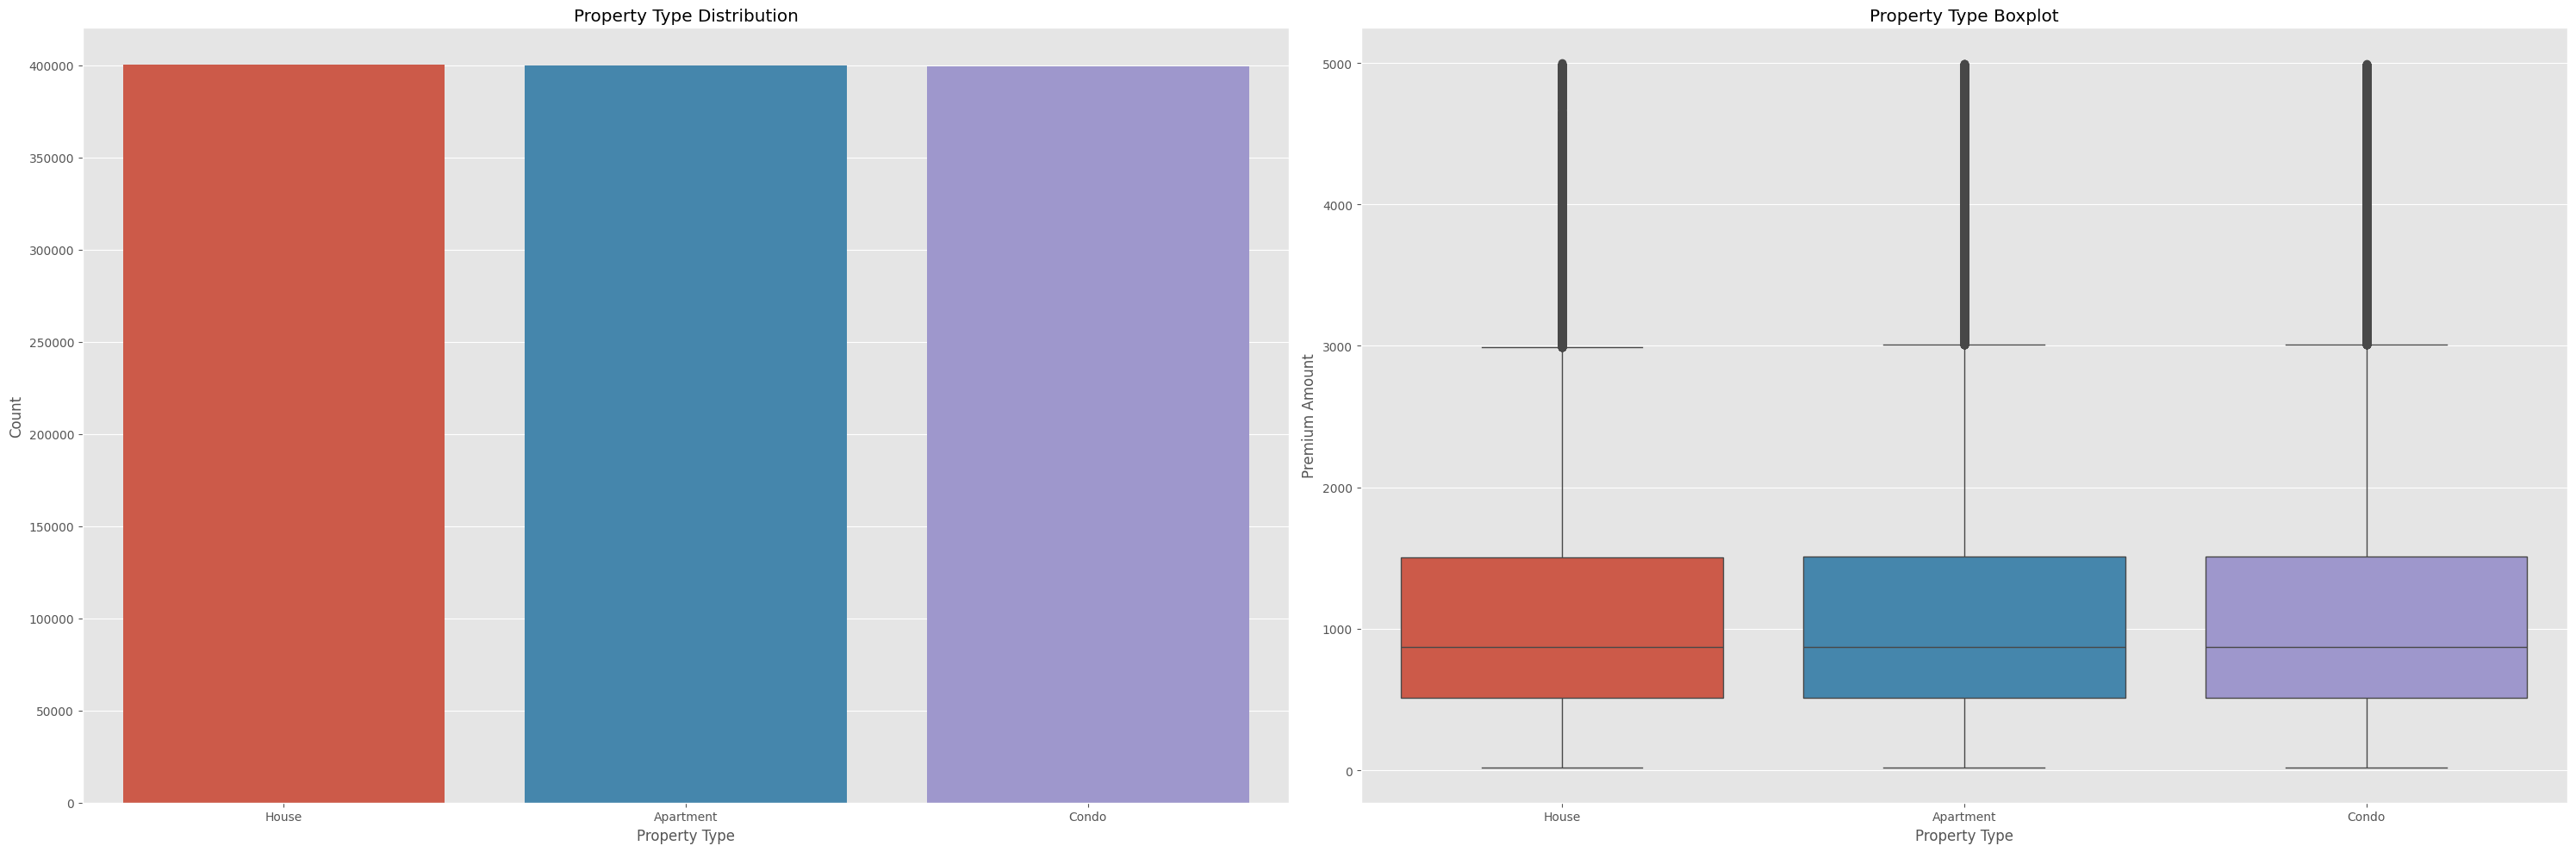

In [21]:
for col in category_columns:
    plot_cat_col(train, col)

In [22]:
Q1 = train['Premium Amount'].quantile(0.25)
Q3 = train['Premium Amount'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 개수 확인
outliers = train[(train['Premium Amount'] < lower_bound) | (train['Premium Amount'] > upper_bound)]
print(f'Number of Outliers: {len(outliers)}')
print(f"Ratio of Outliers: {(len(outliers) / len(train['Premium Amount'])) * 100}%")

Number of Outliers: 49320
Ratio of Outliers: 4.109999999999999%


> **Outlier and Skewness Analysis**  
- A **thick upper whisker** in the box plot suggests the presence of **outliers** in the target variable.  
- Outlier analysis revealed that **4.1% of the data** falls outside the IQR bounds, indicating a moderate level of outliers.  
- Additionally, the target variable was previously identified as **right-skewed**.  
- To address both **outliers** and **skewness**, a **log transformation** will be applied to normalize the distribution and reduce the impact of extreme values.  

In [23]:
train_corr = train[numerical_columns + ["Premium Amount"]].corr()
train_corr

,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount
Age,1.000000,-0.000009,0.001475,0.000881,0.001869,-0.002455,0.002842,-0.000064,-0.002430
Annual Income,-0.000009,1.000000,0.002135,0.025530,0.043065,-0.000500,-0.201423,0.000379,-0.012390
Number of Dependents,0.001475,0.002135,1.000000,0.005152,-0.004123,0.001232,-0.001714,-0.000265,-0.000976
Health Score,0.000881,0.025530,0.005152,1.000000,0.001989,0.000316,0.012016,0.002487,0.014704
Previous Claims,0.001869,0.043065,-0.004123,0.001989,1.000000,-0.001172,0.036816,0.003001,0.046874
Vehicle Age,-0.002455,-0.000500,0.001232,0.000316,-0.001172,1.000000,0.000508,0.003132,0.000391
Credit Score,0.002842,-0.201423,-0.001714,0.012016,0.036816,0.000508,1.000000,0.000493,-0.026014
Insurance Duration,-0.000064,0.000379,-0.000265,0.002487,0.003001,0.003132,0.000493,1.000000,-0.000028
Premium Amount,-0.002430,-0.012390,-0.000976,0.014704,0.046874,0.000391,-0.026014,-0.000028,1.000000


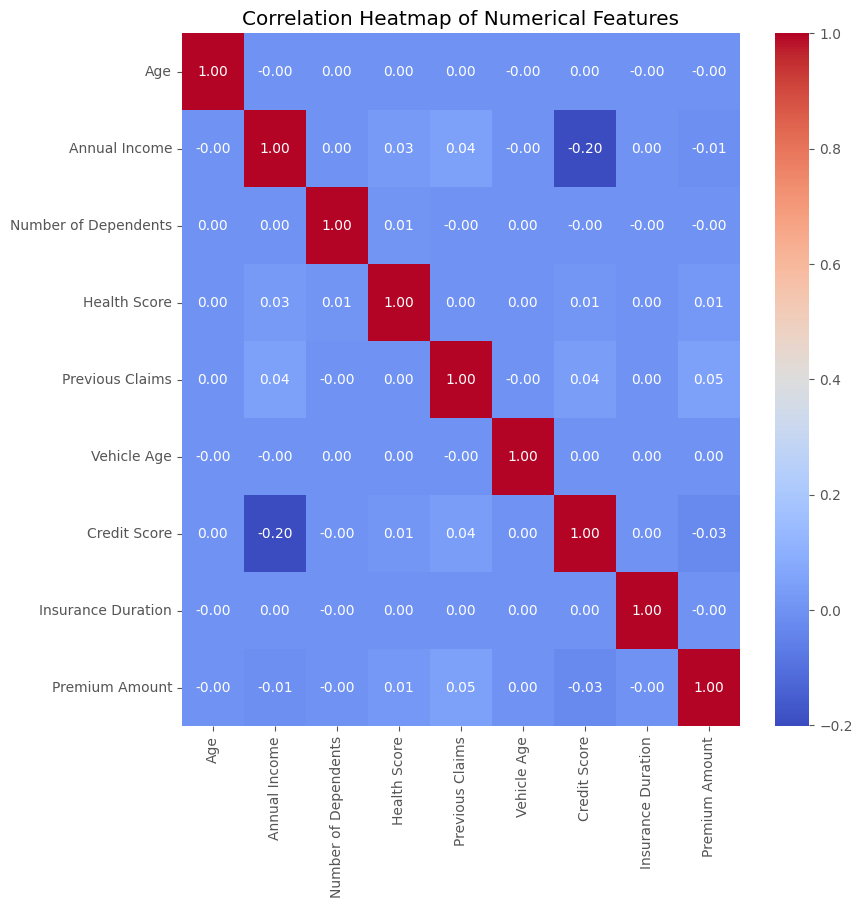

In [24]:
plt.figure(figsize=(9, 9))
sns.heatmap(train_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

> 📊 Feature Analysis Summary

- Most features exhibit low linear correlation with the target.
- There may be **non-linear relationships** between features and the target that are not captured in the current plots.
- Most features show negligible correlation with `Premium Amount`, suggesting potential non-linear relationships or feature interactions to explore further.

# Preprocessing

- In insurance data, **dates** can be important features for capturing **time-based patterns**.  
- However, for the **baseline model**, the **time-related column** ('Policy Start Date') will be **excluded** to simplify the analysis.

In [25]:
train['log_Annual_Income'] = np.log1p(train['Annual Income'])
train['log_Premium_Amount'] = np.log1p(train['Premium Amount'])

In [26]:
train_log = train[['id', 'Age', 'Gender', 'log_Annual_Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'log_Premium_Amount']]

train_log.head()

,id,Age,Gender,log_Annual_Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,log_Premium_Amount
0,0,19.0,Female,9.215328,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,7.962067
1,1,39.0,Female,10.363409,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,7.302496
2,2,23.0,Male,10.150465,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,Good,Yes,Weekly,House,6.342121
3,3,21.0,Male,11.862568,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,Poor,Yes,Daily,Apartment,6.641182
4,4,21.0,Male,10.587897,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,Poor,Yes,Weekly,House,7.612337


In [27]:
features = train.columns.drop(['id', 'log_Premium_Amount'])
features

Index(['Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount', 'log_Annual_Income'],
      dtype='object')

In [28]:
num_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

cat_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessors = ColumnTransformer(
    transformers=[
        ('num', num_preprocessor, numerical_columns),
        ('cat', cat_preprocessor, category_columns),
    ]
)

In [29]:
train_prep = preprocessors.fit_transform(train[features])
test_prep = preprocessors.transform(test)

# Model

In [30]:
y = train['log_Premium_Amount']

In [31]:
x_train, x_val, y_train, y_val = train_test_split(train_prep, y, test_size=0.1, random_state=2024)

## Hyperparmeter

In [34]:
# Define Optuna optimization function
def objective(trial):
    # Define parameter search space
    param = {
        "objective": "regression",
        "metric": "rmse",
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
        "num_leaves": trial.suggest_int("num_leaves", 10, 300),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 5, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 12),  # -1 means no limit
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-4, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.001, 0.1),
        "device_type": "cpu",  # Enable GPU support
        "seed" : 2024,
        'verbose':-1 # 경고 및 로그 메세지 출력 X

    }

    # Create a LightGBM dataset
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_val, label=y_val, reference=dtrain)

    callbacks=[
        lgb.log_evaluation(period=50)
    ]

    # Train LightGBM model
    model = lgb.train(
        param,
        dtrain,
        num_boost_round=200,
        valid_sets=[dtrain, dval],
        valid_names=['train', 'valid'],
        callbacks=callbacks
    )

    # Predict on validation set
    y_val_pred = model.predict(x_val, num_iteration=model.best_iteration)
    
    # Compute RMSLE using sklearn's root_mean_squared_log_error
    rmse = root_mean_squared_error(y_val, np.maximum(y_val_pred, 0))
    return rmse

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

[I 2024-12-23 08:18:01,984] A new study created in memory with name: no-name-8a14293e-8a6f-4e99-956f-390abaec5282


[50]	train's rmse: 1.09391	valid's rmse: 1.09608
[100]	train's rmse: 1.09231	valid's rmse: 1.09449
[150]	train's rmse: 1.09091	valid's rmse: 1.09312


[I 2024-12-23 08:18:07,299] Trial 0 finished with value: 1.092013269400138 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 213, 'learning_rate': 0.001973582511894858, 'feature_fraction': 0.664787298903573, 'bagging_fraction': 0.6786603630487316, 'bagging_freq': 9, 'min_data_in_leaf': 80, 'max_depth': 2, 'lambda_l1': 0.002695871150736623, 'lambda_l2': 1.8310627909855075, 'min_gain_to_split': 0.05742490319339581}. Best is trial 0 with value: 1.092013269400138.


[200]	train's rmse: 1.08979	valid's rmse: 1.09201
[50]	train's rmse: 1.06481	valid's rmse: 1.0674
[100]	train's rmse: 1.0597	valid's rmse: 1.06245
[150]	train's rmse: 1.05772	valid's rmse: 1.06053
[200]	train's rmse: 1.05699	valid's rmse: 1.05989


[I 2024-12-23 08:18:16,256] Trial 1 finished with value: 1.0598883888233417 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 29, 'learning_rate': 0.07994200282798601, 'feature_fraction': 0.6750130298118135, 'bagging_fraction': 0.7381392465929568, 'bagging_freq': 5, 'min_data_in_leaf': 51, 'max_depth': 3, 'lambda_l1': 0.003373942212124816, 'lambda_l2': 0.000145350006496562, 'min_gain_to_split': 0.04223112215833351}. Best is trial 1 with value: 1.0598883888233417.


[50]	train's rmse: 1.09528	valid's rmse: 1.09742
[100]	train's rmse: 1.09496	valid's rmse: 1.09711
[150]	train's rmse: 1.09465	valid's rmse: 1.0968


[I 2024-12-23 08:18:21,986] Trial 2 finished with value: 1.0965578173598596 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 40, 'learning_rate': 0.000600108935139011, 'feature_fraction': 0.8098585854727671, 'bagging_fraction': 0.8770238670545789, 'bagging_freq': 7, 'min_data_in_leaf': 29, 'max_depth': 1, 'lambda_l1': 0.01008550512398551, 'lambda_l2': 0.5464907019874681, 'min_gain_to_split': 0.0025185080801837043}. Best is trial 1 with value: 1.0598883888233417.


[200]	train's rmse: 1.0944	valid's rmse: 1.09656
[50]	train's rmse: 1.0941	valid's rmse: 1.09629
[100]	train's rmse: 1.09277	valid's rmse: 1.09501
[150]	train's rmse: 1.09134	valid's rmse: 1.09363
[200]	train's rmse: 1.0903	valid's rmse: 1.09264


[I 2024-12-23 08:18:44,535] Trial 3 finished with value: 1.092637652891742 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 277, 'learning_rate': 0.00043927270247969127, 'feature_fraction': 0.8196165102658332, 'bagging_fraction': 0.8919388941791861, 'bagging_freq': 8, 'min_data_in_leaf': 10, 'max_depth': 11, 'lambda_l1': 3.304094523799043, 'lambda_l2': 0.029441195392459058, 'min_gain_to_split': 0.022912056834823988}. Best is trial 1 with value: 1.0598883888233417.


[50]	train's rmse: 1.09386	valid's rmse: 1.09603
[100]	train's rmse: 1.09222	valid's rmse: 1.09441
[150]	train's rmse: 1.09056	valid's rmse: 1.09277
[200]	train's rmse: 1.08932	valid's rmse: 1.09155


[I 2024-12-23 08:19:01,255] Trial 4 finished with value: 1.0915535299405703 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 106, 'learning_rate': 0.0004976722810707913, 'feature_fraction': 0.8750216142865834, 'bagging_fraction': 0.6183127194593988, 'bagging_freq': 8, 'min_data_in_leaf': 44, 'max_depth': 9, 'lambda_l1': 2.5653353216584427, 'lambda_l2': 0.00343089155501689, 'min_gain_to_split': 0.09161143170614718}. Best is trial 1 with value: 1.0598883888233417.


[50]	train's rmse: 1.09536	valid's rmse: 1.0975
[100]	train's rmse: 1.09511	valid's rmse: 1.09726
[150]	train's rmse: 1.09488	valid's rmse: 1.09702
[200]	train's rmse: 1.09467	valid's rmse: 1.09682


[I 2024-12-23 08:19:13,749] Trial 5 finished with value: 1.0968190077268665 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 147, 'learning_rate': 0.0001320223873130106, 'feature_fraction': 0.6674642717279917, 'bagging_fraction': 0.7569726641721263, 'bagging_freq': 9, 'min_data_in_leaf': 22, 'max_depth': 6, 'lambda_l1': 0.00018350505534815196, 'lambda_l2': 1.1711989069198092, 'min_gain_to_split': 0.05017370128249437}. Best is trial 1 with value: 1.0598883888233417.


[50]	train's rmse: 1.06622	valid's rmse: 1.06926
[100]	train's rmse: 1.05542	valid's rmse: 1.05937
[150]	train's rmse: 1.05035	valid's rmse: 1.05522
[200]	train's rmse: 1.04791	valid's rmse: 1.05359


[I 2024-12-23 08:19:33,426] Trial 6 finished with value: 1.0535852870753233 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 121, 'learning_rate': 0.020323316700115477, 'feature_fraction': 0.6542684147715762, 'bagging_fraction': 0.98760594563211, 'bagging_freq': 7, 'min_data_in_leaf': 45, 'max_depth': 10, 'lambda_l1': 0.0014886571601557758, 'lambda_l2': 0.0032345539497010845, 'min_gain_to_split': 0.07769081626574381}. Best is trial 6 with value: 1.0535852870753233.


[50]	train's rmse: 1.09071	valid's rmse: 1.09294
[100]	train's rmse: 1.08725	valid's rmse: 1.08952
[150]	train's rmse: 1.08461	valid's rmse: 1.08693


[I 2024-12-23 08:19:39,590] Trial 7 finished with value: 1.0851470536496 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 33, 'learning_rate': 0.005362940583671537, 'feature_fraction': 0.7298263882035935, 'bagging_fraction': 0.6552961002761515, 'bagging_freq': 12, 'min_data_in_leaf': 22, 'max_depth': 2, 'lambda_l1': 3.475896749534, 'lambda_l2': 0.24454221375637622, 'min_gain_to_split': 0.013061519481576335}. Best is trial 6 with value: 1.0535852870753233.


[200]	train's rmse: 1.08279	valid's rmse: 1.08515
[50]	train's rmse: 4.85421	valid's rmse: 4.85253
[100]	train's rmse: 4.97566	valid's rmse: 4.974
[150]	train's rmse: 4.80042	valid's rmse: 4.79884
[200]	train's rmse: 4.65873	valid's rmse: 4.6572


[I 2024-12-23 08:20:56,916] Trial 8 finished with value: 4.657201761369654 and parameters: {'boosting_type': 'dart', 'num_leaves': 166, 'learning_rate': 0.0030432775530535323, 'feature_fraction': 0.9935414877878228, 'bagging_fraction': 0.6145216555196565, 'bagging_freq': 7, 'min_data_in_leaf': 43, 'max_depth': 11, 'lambda_l1': 0.00015562304370429552, 'lambda_l2': 0.00014475378444161642, 'min_gain_to_split': 0.09600067098174077}. Best is trial 6 with value: 1.0535852870753233.


[50]	train's rmse: 4.9798	valid's rmse: 4.97804
[100]	train's rmse: 5.22979	valid's rmse: 5.228
[150]	train's rmse: 5.20903	valid's rmse: 5.20725


[I 2024-12-23 08:21:09,874] Trial 9 finished with value: 5.173642488002687 and parameters: {'boosting_type': 'dart', 'num_leaves': 147, 'learning_rate': 0.0012212493163608416, 'feature_fraction': 0.7072769285187182, 'bagging_fraction': 0.7523934457268754, 'bagging_freq': 7, 'min_data_in_leaf': 10, 'max_depth': 1, 'lambda_l1': 0.002826923370154879, 'lambda_l2': 0.0034480123044239694, 'min_gain_to_split': 0.003721802821940349}. Best is trial 6 with value: 1.0535852870753233.


[200]	train's rmse: 5.17542	valid's rmse: 5.17364


In [35]:
study.best_params, study.best_value

({'boosting_type': 'gbdt',
  'num_leaves': 121,
  'learning_rate': 0.020323316700115477,
  'feature_fraction': 0.6542684147715762,
  'bagging_fraction': 0.98760594563211,
  'bagging_freq': 7,
  'min_data_in_leaf': 45,
  'max_depth': 10,
  'lambda_l1': 0.0014886571601557758,
  'lambda_l2': 0.0032345539497010845,
  'min_gain_to_split': 0.07769081626574381},
 1.0535852870753233)

## Train

In [37]:
# Train final model with best parameters
best_params = study.best_params

dtrain = lgb.Dataset(x_train, label=y_train)
dval = lgb.Dataset(x_val, label=y_val, reference=dtrain)

callbacks = [
    lgb.early_stopping(200),
    lgb.log_evaluation(period=50)
]

model_lgb = lgb.train(
    best_params,
    dtrain,
    num_boost_round=5000,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'valid'],
    callbacks=callbacks
)

Training until validation scores don't improve for 200 rounds


[50]	train's l2: 1.13911	valid's l2: 1.14546
[100]	train's l2: 1.11482	valid's l2: 1.123
[150]	train's l2: 1.10381	valid's l2: 1.1138
[200]	train's l2: 1.09799	valid's l2: 1.1097
[250]	train's l2: 1.09426	valid's l2: 1.10775
[300]	train's l2: 1.09209	valid's l2: 1.10712
[350]	train's l2: 1.09017	valid's l2: 1.10673
[400]	train's l2: 1.08824	valid's l2: 1.10651
[450]	train's l2: 1.08668	valid's l2: 1.1063
[500]	train's l2: 1.08531	valid's l2: 1.10623
[550]	train's l2: 1.08391	valid's l2: 1.10622
[600]	train's l2: 1.0825	valid's l2: 1.10616
[650]	train's l2: 1.08118	valid's l2: 1.10611
[700]	train's l2: 1.0799	valid's l2: 1.10605
[750]	train's l2: 1.07868	valid's l2: 1.10605
[800]	train's l2: 1.07734	valid's l2: 1.10606
[850]	train's l2: 1.07603	valid's l2: 1.10599
[900]	train's l2: 1.07482	valid's l2: 1.10598
[950]	train's l2: 1.07361	valid's l2: 1.10599
[1000]	train's l2: 1.0724	valid's l2: 1.10594
[1050]	train's l2: 1.07115	valid's l2: 1.10596
[1100]	train's l2: 1.07	valid's l2: 1.106

# Evaluation

In [38]:
y_val_pred = model_lgb.predict(x_val)

rmse = root_mean_squared_error(y_val, y_val_pred)
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"\nPerformance Metrics:\n{'-'*30}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")


Performance Metrics:
------------------------------
RMSE: 1.0516
MAE: 0.7469
R²: 0.0823


/tmp/ipykernel_85550/3496831211.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")


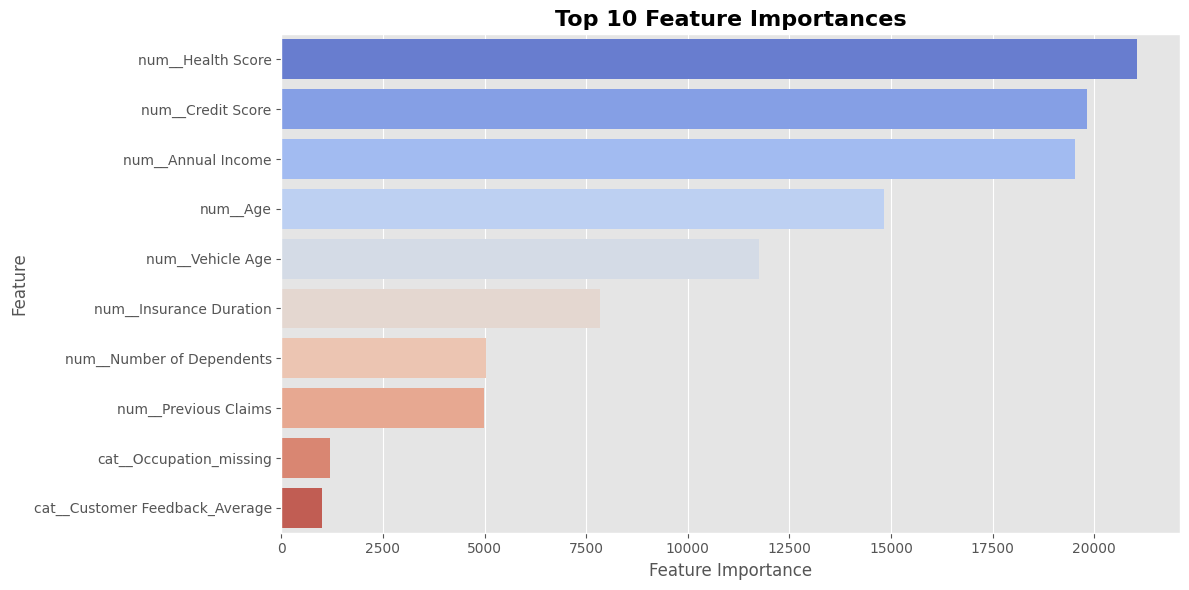

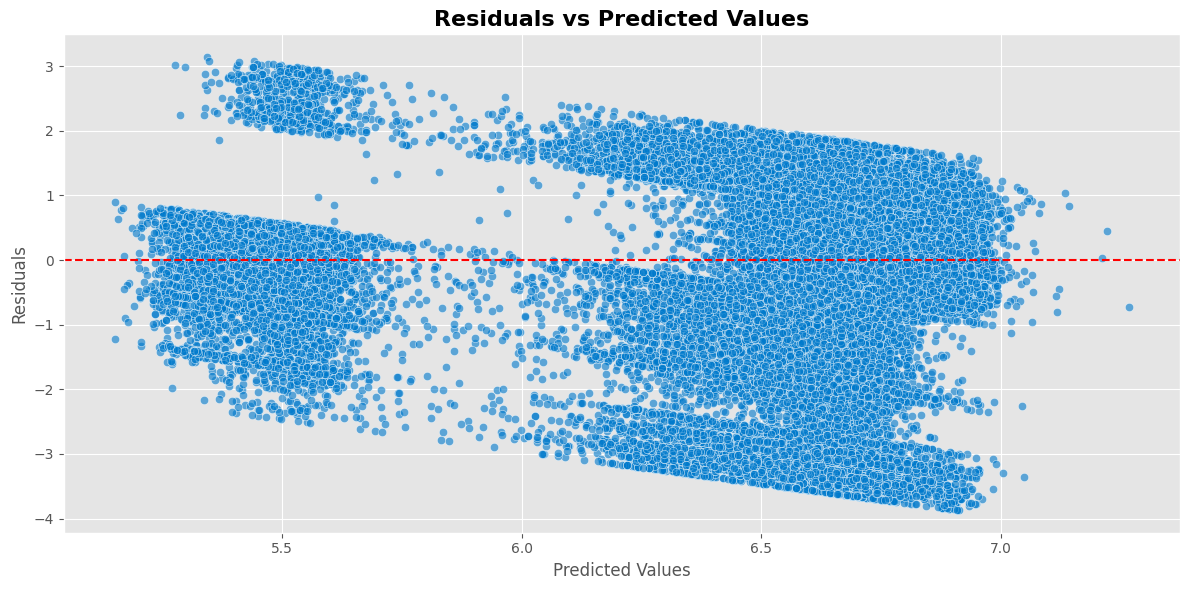

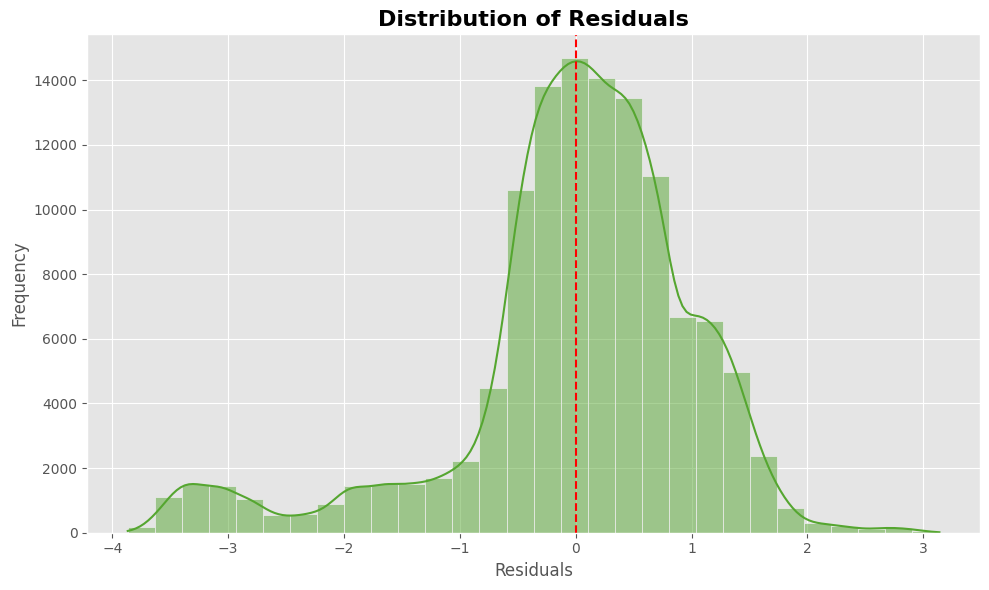

In [44]:
# 2. Feature Importance
importances = model_lgb.feature_importance(importance_type='split')  # or 'gain'
features = preprocessors.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': [features[i] for i in sorted_indices],
    'Importance': importances[sorted_indices]
})

# Plot top 10 feature importances
plt.figure(figsize=(12, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette="coolwarm")
plt.title("Top 10 Feature Importances", fontsize=16, fontweight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()

# 3. Residual Analysis
residuals = y_val - y_val_pred

# Residuals vs Predicted Values
plt.figure(figsize=(12, 6))
sns.scatterplot(x=y_val_pred, y=residuals, alpha=0.6, color="#007acc")
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Residuals vs Predicted Values", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color="#55a630")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1.5)
plt.title("Distribution of Residuals", fontsize=16, fontweight='bold')
plt.xlabel("Residuals", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout()
plt.show()

# Submission

In [39]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [40]:
preds = model_lgb.predict(test_prep)
preds_exp = np.expm1(preds)
submission['Premium Amount'] = preds_exp
submission.head(20)

,id,Premium Amount
0,1200000,828.698163
1,1200001,832.609127
2,1200002,802.027319
3,1200003,806.661086
4,1200004,743.037905
5,1200005,817.391623
6,1200006,971.805056
7,1200007,701.841094
8,1200008,222.404440
9,1200009,820.602080


In [41]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              800000 non-null  int64  
 1   Premium Amount  800000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 12.2 MB


In [42]:
submission.to_csv('./data/01_baseline_submission.csv', index=False)
!kaggle competitions submit -c playground-series-s4e12 -f "./data/01_baseline_submission.csv" -m "01_baseline"

100%|██████████████████████████████████████| 19.8M/19.8M [00:00<00:00, 41.9MB/s]
Successfully submitted to Regression with an Insurance Dataset

> Public Score : 1.04849
- 498 / 1653